# Readme

## Running
All you need to do is configure `DATA_DIR` and `PARTITION`, and later `MODEL_ROOT`

## Logs and param configuration
- see this notebook outputs
- see [wandb](https://wandb.ai/school_stuff/hw4p2?nw=nwuserzzyatcmu)
- Note that early experiments are not in wandb, refer to [HW4P2_S24_Student_Starter_V3_locallog](./HW4P2_S24_Student_Starter_V3_locallog.ipynb) for the local outputs.

# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>**attention**</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

<h2>Learning Objectives:

*  **Understand the Transformer Architecture**: Gain a comprehensive understanding of the transformer model architecture.

*  **Develop the  Encoder and Decoder Modules**: Understand the individual components of the transformer's encoder and decoder modules, including positional encoding, multi-head attention, and feed-forward projections.

*  **Integrate the Complete Transformer Model**:  Combine the encoder and decoder modules to construct the full transformer model, and learn how to manage the flow of information between these components.

* **Understand the Value of Multi-Head Attention**: Learn how to use the multi-head attention mechanism and understand its significance in improving the model's ability to focus on different parts of the input sequence simultaneously.

* **Understand and Apply Pretraining Techniques**: Grasp the concept of pretraining by employing LSTMs as an initial embedding mechanism in a transformer's encoder. Learn the strategic process of incrementally training different components of a model — starting with a simple architecture (LSTM), then progressing to more complex structures (transformers). This objective underscores the role of pretraining and its gradual integration to enhance the overall efficacy of neural network models, culminating in superior performance metrics.

* **Enhance Training Efficiency Through Strategic Freezing**: Master the technique of selectively freezing and unfreezing model components at different stages of training. This approach aims to direct the model's learning capacity more effectively, concentrating on specific modules at a time. Understand how this method facilitates a more efficient training process, allowing various parts of the model to adapt incrementally. This objective highlights the value of phased learning, especially beneficial when integrating model components with varying learning dynamics.

*  **Tune Model Hyperparameters**: Experiment with different configurations of model hyperparameters, such as the number of layers, model dimensionality, and the number of attention heads, to help you understand the tradeoff between model complexity and dataset size.

<br>


[Kaggle Competition Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24)<br>

[Kaggle Dataset Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24/data)<br>

[Speech Transformer Paper](https://ieeexplore.ieee.org/document/8462506)<br>

[Attention Is All You Need Paper](https://arxiv.org/pdf/1706.03762.pdf)<br>

# Libraries

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [1]:
!nvidia-smi

Sat Apr 27 17:27:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.65                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0 Off |                  Off |
| 32%   33C    P8             28W /  520W |    3648MiB /  24564MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# ''' Installing some required libraries. '''
# !pip install python-levenshtein torchsummaryX wandb kaggle pytorch-nlp --quiet

##  Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as tat

from torchsummaryX import summary
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import gc
import os
import math
import yaml
import random
import zipfile
import datetime

import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

''' Imports for decoding and distance calculation. '''
import Levenshtein

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


# Configurations

In [159]:
%%writefile config3.yaml

###### Dataset -----------------------------------------------------------------
train_dataset   : "train-clean-100"     # train-clean-50 (primarily for debugging purposes), train-clean-100
cepstral_norm   : True
input_dim       : 27
batch_size      : 32                    # decrease this as you modify the network architecture

###### Encoder Parameters ------------------------------------------
## Universal (Part I and II)
enc_dropout     : 0.3                   # [0.1, 0.4]
## Transformer-related (Part II)
enc_num_layers  : 1                     # [1, 3]
enc_num_heads   : 3                     # [1, 4]

###### Decoder Parameters ------------------------------------------
## Transformer-related (Part I and II)
dec_dropout     : 0.2                 # [0.1, 0.4]
dec_num_layers  : 3                     # [1, 3]
dec_num_heads   : 3                   # [1, 4]

###### Network Parameters ------------------------------------------------------
d_model         : 512                   # [256, 1024]
d_ff            : 2048                  # [512, 4096]

###### Learning Rate ---------------------------------------------------------------
learning_rate   : 2E-4                  # [1E-3, 1E-4], this will depend on the specified optimizer
learning_rate_2 : 5E-5

###### Optimizer ---------------------------------------------------------------
optimizer       : "AdamW"               # Adam, AdamW

## if SGD
momentum        : 0.0
nesterov        : True

###### Scheduler ---------------------------------------------------------------
scheduler       : "ReduceLR"     # CosineAnnealing, ReduceLR

## if ReduceLR

## we are validating every 2 epochs but scheduler acts on every epoch. Set patience accordingly
## patience less than validation frquency can mean learning rate always dropping after patience epochs
## specify a suitable threshold too
factor          : 0.5
patience        : 6

###### Training Parameters -----------------------------------------------------
epochs          : 80

###### Name --------------------------------------------------------------------
Name: ""                                # write your name here for study group

Overwriting config3.yaml


In [160]:
with open("config3.yaml") as file:
    config = yaml.safe_load(file)

In [161]:
config

{'train_dataset': 'train-clean-100',
 'cepstral_norm': True,
 'input_dim': 27,
 'batch_size': 32,
 'enc_dropout': 0.3,
 'enc_num_layers': 1,
 'enc_num_heads': 3,
 'dec_dropout': 0.2,
 'dec_num_layers': 3,
 'dec_num_heads': 3,
 'd_model': 512,
 'd_ff': 2048,
 'learning_rate': '2E-4',
 'learning_rate_2': '5E-5',
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'scheduler': 'ReduceLR',
 'factor': 0.5,
 'patience': 6,
 'epochs': 80,
 'Name': ''}

# Kaggle Dataset Download

In [7]:
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:

#     # Enter your kaggle username <USERNAME> and key <KEY> here.
#     f.write('{"username":"<USERNAME>","key":"<KEY>"}')

# !chmod 600 /root/.kaggle/kaggle.json

In [8]:
# ''' Downloading the dataset. '''
# !kaggle competitions download -c automatic-speech-recognition-s24

# ''' Unzipping quickly and quietly. '''
# !unzip -q automatic-speech-recognition-s24.zip -d ./data

# Character-based LibriSpeech (HW4P2)

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar.

Can you spot out the differences? What all will be required??

Hints:

- Check how big is the dataset? (do you require memory efficient loading techniques??)
- How do we load MFCCs? Do we need to normalize them?
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB -- is the dataset same as HW3P2?
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [9]:
VOCAB = [
    "<pad>", "<sos>", "<eos>",
    "A",   "B",    "C",    "D",
    "E",   "F",    "G",    "H",
    "I",   "J",    "K",    "L",
    "M",   "N",    "O",    "P",
    "Q",   "R",    "S",    "T",
    "U",   "V",    "W",    "X",
    "Y",   "Z",    "'",    " ",
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

Length of Vocabulary    : 31
VOCAB                   : ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN               : 0
SOS_TOKEN               : 1
EOS_TOKEN               : 2


## Dataset

In [10]:
''' This class is very similar to HW3P2 except for targets (now sequence of characters). '''
from tqdm import tqdm

class SpeechDataset(torch.utils.data.Dataset):
    ''' memory inefficient : loading data in __init__ for simplicty

        You may decide to load data in __getitem__ if you wish.
        However, doing this memory inefficiently makes __init__ function takes
        the load of loading the data, and shifts it away from during the training process.
    '''

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir           = f"{root_dir}/{partition}*/mfcc/*"
        self.transcript_dir     = f"{root_dir}/{partition}*/transcripts/*"

        self.mfcc_files         = sorted(glob.glob(self.mfcc_dir))
        self.transcript_files   = sorted(glob.glob(self.transcript_dir))

        assert len(self.mfcc_files) == len(self.transcript_files)

        self.mfcc_files         = self.mfcc_files
        self.transcript_files   = self.transcript_files
        self.length             = len(self.transcript_files)
        self.vocab              = VOCAB

        print("Loaded Path: ", partition)

        self.mfccs, self.transcripts_shifted, self.transcripts_golden  = [], [], []
        for file in tqdm(self.mfcc_files):
            mfcc = np.load(file)

            if cepstral:
                mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        for file in tqdm(self.transcript_files):
            temp = np.load(file)[1:-1]

            # Why do we have two different types of targets?
            # How do we want our decoder to know the start of sequence <SOS> and end of sequence <EOS>?

            # @TODO: Uncomment the code below after answering the above questions.
            self.transcripts_shifted.append(np.array([SOS_TOKEN] + [self.vocab.index(i) for i in temp]))
            self.transcripts_golden.append(np.array([self.vocab.index(i) for i in temp] + [EOS_TOKEN]))

        assert len(self.mfccs) == len(self.transcripts_shifted)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc                = torch.FloatTensor(self.mfccs[ind])
        shifted_transcript  = torch.tensor(self.transcripts_shifted[ind])
        golden_transcript   = torch.tensor(self.transcripts_golden[ind])

        return mfcc, shifted_transcript, golden_transcript


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad both features and labels,
            look at PyTorch's documentation for pad_sequence.
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lengths of features, and lengths of labels.

        '''

        # Batch of input mfcc coefficients.
        batch_mfcc              = [i[0] for i in batch]

        # Batch of output characters (shifted and golden).
        batch_transcript        = [i[1] for i in batch]
        batch_golden            = [i[2] for i in batch]

        lengths_mfcc            = [len(i) for i in batch_mfcc]
        lengths_transcript      = [len(i) for i in batch_transcript]

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first).
        batch_mfcc_pad          = pad_sequence(batch_mfcc, batch_first=True, padding_value=PAD_TOKEN)
        batch_transcript_pad    = pad_sequence(batch_transcript, batch_first=True, padding_value=PAD_TOKEN)
        batch_golden_pad        = pad_sequence(batch_golden, batch_first=True, padding_value=PAD_TOKEN)


        # You may apply some transformations, Time and Frequency masking, here in the collate function:
        # Food for Thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?


        # Return the following values:
        # padded features, padded shifted labels, padded golden labels, actual length of features, actual length of the shifted labels
        return batch_mfcc_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [11]:
class SpeechTestDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir       = f"{root_dir}/{partition}*/mfcc/*"
        self.mfcc_files     = sorted(glob.glob(self.mfcc_dir))
        self.length         = len(self.mfcc_files)

        self.mfccs = []
        for file in tqdm(self.mfcc_files):
            mfcc = np.load(file)
            if cepstral: mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        print("Loaded Path: ", partition)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]

        return torch.FloatTensor(mfcc)


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        TODO:
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad the features,
            look at PyTorch's documentation for pad_sequence.
        3.  Return batch of features, lengths of features.

        '''

        batch_mfcc      = batch
        batch_mfcc_pad  = pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc    = [len(i) for i in batch_mfcc]

        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [12]:
# @NOTE: use the config file to specify PARTITION and CEPSTRAL
DATA_DIR        = "/mnt/e/Workspace/IDL/Data/hw4/11785-HW4P2"                # Enter your data directory here.
PARTITION       = "train-clean-100"                # Enter your training directory here.
CEPSTRAL        = True                # Enter your cepstral_norm parameter here.

train_dataset   = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL
)

val_dataset     = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = "dev-clean",
    cepstral    = CEPSTRAL
)

test_dataset    = SpeechTestDataset(
    root_dir    = DATA_DIR,
    partition   = "test-clean",
    cepstral    = CEPSTRAL,
)

gc.collect()

Loaded Path:  train-clean-100


  0%|          | 51/28539 [00:00<03:53, 121.84it/s]

100%|██████████| 28539/28539 [02:37<00:00, 181.73it/s]


Loaded Path:  dev-clean


100%|██████████| 2620/2620 [00:17<00:00, 149.11it/s]

Loaded Path:  test-clean


834

## DataLoader

In [97]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = 16,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 8,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn,
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn,
)

print("No. of Train MFCCs   : ", train_dataset.__len__())
print("Batch Size           : ", config["batch_size"])
print("Train Vatches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())
print("Test Batches         : ", test_loader.__len__())

No. of Train MFCCs   :  28539
Batch Size           :  32
Train Vatches        :  892
Val Batches          :  85
Test Batches         :  82


In [98]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # print(y_shifted_pad)

    break

Checking the Shapes of the Data --

x_pad shape:		torch.Size([32, 1596, 27])
x_len shape:		torch.Size([32])

y_shifted_pad shape:	torch.Size([32, 259])
y_golden_pad shape:	torch.Size([32, 259])
y_len shape:		torch.Size([32])



## DataLoader Verification

- Train Dataset (train-clean-50)
```
Loaded Path:  train-clean-50
Max MFCC Length          :  1982
Avg MFCC Length          :  1256.06069100848
Max Transcript Length    :  354
Max Transcript Length    :  182.2676431424767
```

- Train Dataset (train-clean-100)
```
Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  186.65321139493324
```

- Validation Dataset
```
Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547
```

- Test Dataset
```
Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0
```

- Population Stats
```
Max Length:  3260
```

If your values is not matching, read hints and think what could have gone wrong. Then approach TAs.



In [99]:
def verify_dataset(dataset, partition="train-clean-100"):
    print("Loaded Path: ", partition)

    if partition != "test-clean":
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.max([data[1].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.mean([data[1].shape[0] for data in dataset]))
    else:
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))

    print()

verify_dataset(train_dataset, partition="train-clean-100")
verify_dataset(val_dataset, partition="dev-clean")
verify_dataset(test_dataset, partition="test-clean")

dataset_max_len = max(
    np.max([data[0].shape[0] for data in train_dataset]),
    np.max([data[0].shape[0] for data in val_dataset]),
    np.max([data[0].shape[0] for data in test_dataset]),
)

print("Max Length: ", dataset_max_len)

Loaded Path:  train-clean-100


Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  185.65321139493324

Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547

Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0

Max Length:  3260


# Introduction

Transformers are highly effective for speech recognition tasks because they utilize self-attention mechanisms, enabling them to analyze entire sequences of audio data in one shot. This allows for a nuanced understanding of long-range dependencies and the complex temporal dynamics inherent in speech. Compared to traditional models, transformers offer improved accuracy and efficiency, adeptly handling variations in speech patterns, accents, and intonations; thus, making them exceptionally suitable for advanced speech recognition applications.

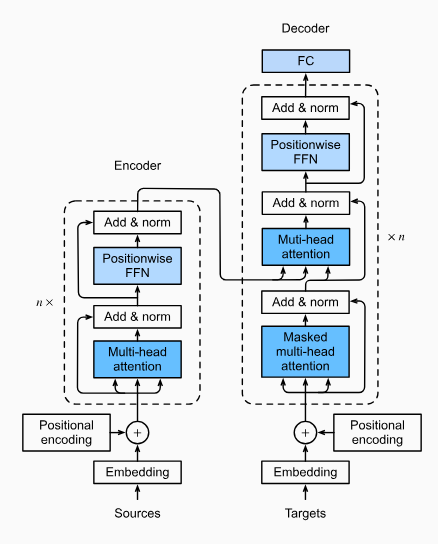

Given the complicated nature of these models, training in this homework will be a little different from other homeworks.<br>
We will employ the following to effectively train the transformer with fewer resources (data and compute power).
<br>
* **Data Complexity and Model Capacity**:  Starting with a CNN-LSTM for input sequences captures temporal dynamics and dependencies early on, simplifying initial learning. This is effective for data with strong temporal or sequential patterns, which LSTMs excel at handling. We will use an already trained model (trained in HW3P2).


* **Gradual (Incremental) Learning**: Starting with a simpler model (like an LSTM) allows the neural network to first learn the basic structures and patterns in the data. When we later introduce more complex mechanisms (like a transformer encoder), the model already has a foundational understanding of the data. This foundation can lead to a smoother and more effective learning process when the complexity of the model increases. In other words, we are using a simple, pretrained LSTM encoder as the basis for our transformer decoder and incrementally adding complexity!

* **Learning Efficiency**: By freezing certain parts of the model during different stages of training, we focus the learning capacity of the network on specific modules, making the training process more efficient. This stepwise unfreezing and training allows different components of the model to adapt gradually, which can be very useful when integrating parts of the model that learn at different rates.

* **Adaptation to Data Characteristics**: This strategy implicitly takes advantage of the data's characteristics by adjusting the model's architecture and training procedure to better suit the data's structure. For instance, if the data contains intricate sequential patterns, starting with an LSTM can harness these patterns effectively. Then, by introducing a transformer encoder, the model can further learn to capture complex, long-range dependencies within the data, something transformers are exceptionally good at.


## Utilities

To make make building the transformer easy, we will define various utility functions and classes which corresponds to the various modules of the transformer. All Components are provided for you but your task will be too understand the modules as you will need  them in answering Canvas quizzes as well as implementing other parts of this notebook. Please refer to the write-up for more information.

In [100]:
def create_mask_1(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

    assert input_lengths is not None or pad_idx is not None

    # Create a mask based on input_lengths
    if input_lengths is not None:
        N = padded_input.size(0)        # padded_input : (N x T x ...)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # (N x T)

        # Set the mask to 0 for padding positions
        for i in range(N):
          non_pad_mask[i, input_lengths[i]:] = 0

    if pad_idx is not None:             # padded_input : N x T

        assert padded_input.dim() == 2

        # Create a mask where non-padding positions are marked with 1 and padding positions are marked with 0
        non_pad_mask = padded_input.ne(pad_idx).float()

    return non_pad_mask.unsqueeze(-1)   # unsqueeze(-1) for broadcasting

In [101]:
def create_mask_2(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
      len_q = seq.size(1)

      # Create a mask where padding positions in the key sequence are marked with 1.
      padding_mask  = seq.eq(pad_idx)

      # Expand the mask to match the dimensions of the key-query attention matrix.
      padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
      mask          = (padding_mask + mask).gt(0)

    else:
      mask = mask.gt(0)

    return mask

In [102]:
def create_mask_3(padded_input, input_lengths, expand_length):
    """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

    Args:
        padded_input: The input tensor with padding, shape (N, Ti, ...).
        input_lengths: The actual lengths of each sequence before padding, shape (N,).
        expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

    Returns:
        An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
    """

    # Create a mask to identify non-padding positions, shape (N, Ti, 1)
    # (N x Ti x 1)
    non_pad_mask    = create_mask_1(padded_input, input_lengths=input_lengths)

    # Invert the mask to identify padding positions, shape (N, Ti)
    # N x Ti, lt(1) like-not operation
    pad_mask        = non_pad_mask.squeeze(-1).lt(1)


    # Expand the mask to match the dimensions of the attention matrix, shape (N, expand_length, Ti)
    attn_mask       = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)

    return attn_mask

In [103]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=2)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        attn = torch.bmm(q, k.transpose(1, 2))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            mask_value = -1e+30 if attn.dtype == torch.float32 else -1e+4
            attn = attn.masked_fill(mask, mask_value)

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        attn    = self.dropout(attn)

        # Compute the weighted sum of values based on the attention weights.
        output  = torch.bmm(attn, v)

        return output, attn # Return the attention output and the attention weights.

In [104]:
def save_attention_plot(attention_weights, epoch=0, folder=''):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="GnBu")  # Create heatmap

    # Save the plot to a file. Specify the directory if needed.
    plt.savefig(f"{folder}cross_attention-epoch{epoch}.png")

In [105]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)

        torch.nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output          = output.view(n_head, sz_b, len_q, d_v)
        output          = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output          = self.dropout(self.fc(output))

        return output, attn

## Transformer Modules

### Positional Encoding

In [106]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):

      return x + self.pe[:, :x.size(1)]

### Feed Forward Networks

In [107]:
class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.mish(self.linear_1(x)))

         # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x

# PART #1 (Preliminary Submission)

In this part we will use a simple CNN-LSTM as an encoder with a Transformer Decoder (with Self-Attention and Cross-Attention).

## CNN-LSTM Encoder

In [108]:
class Permute(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [109]:
class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)

    def forward(self, x_packed):
        x_padded, x_lens = pad_packed_sequence(x_packed, batch_first=True)
        x_padded, x_lens = self.trunc_reshape(x_padded, x_lens)
        x_packed = pack_padded_sequence(x_padded, x_lens, batch_first=True, enforce_sorted=False)
        output_packed, hidden = self.blstm(x_packed)
        return output_packed

    def trunc_reshape(self, x, x_lens):
        if x.shape[1]%2==1:
            x = x[:,:-1,:]
        x = x.reshape((x.shape[0], int(x.shape[1]//2), x.shape[2]*2))
        x_lens = (x_lens/2).type(torch.int)
        return x, x_lens

In [110]:
from torch.autograd import Variable

class LockedDropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        x_unpacked, x_lens = pad_packed_sequence(x, batch_first=True)
        m = x.data.new(x_unpacked.size(0), 1, x_unpacked.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x_unpacked)
        out = mask * x_unpacked
        return pack_padded_sequence(out, lengths=x_lens, batch_first=True, enforce_sorted=False)

In [111]:
class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

class CNN_LSTM_Encoder(torch.nn.Module):
    ''' The Encoder takes utterances as inputs and returns latent feature representations '''

    def __init__(self, input_size, encoder_hidden_size, enc_dropout=0.2):
        super(CNN_LSTM_Encoder, self).__init__()

        self.embedding = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, 2*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(2*input_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(2*input_size, 4*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(4*input_size),
            torch.nn.ReLU(inplace=True)
        )

        self.bilstm = torch.nn.LSTM(input_size=4*input_size, hidden_size=encoder_hidden_size, bidirectional=True, batch_first=True, dropout=enc_dropout)

        self.pBLSTMs = torch.nn.Sequential(
            pBLSTM(2 * encoder_hidden_size, encoder_hidden_size),
            LockedDropout(dropout=2*enc_dropout),
            pBLSTM(2*encoder_hidden_size, 2*encoder_hidden_size),
            LockedDropout(dropout=enc_dropout),
        )

        self.permute = PermuteBlock()

    def forward(self, x, x_lens):
        x = self.permute(x)
        x = self.embedding(x)
        x = self.permute(x)

        x_packed        = pack_padded_sequence(x, x_lens, batch_first= True, enforce_sorted=False)
        x_packed, _     = self.bilstm(x_packed)
        x_packed        = self.pBLSTMs(x_packed)
        encoder_outputs, encoder_lens = pad_packed_sequence(x_packed, batch_first=True)

        return encoder_outputs, encoder_lens

## Transformer Decoder

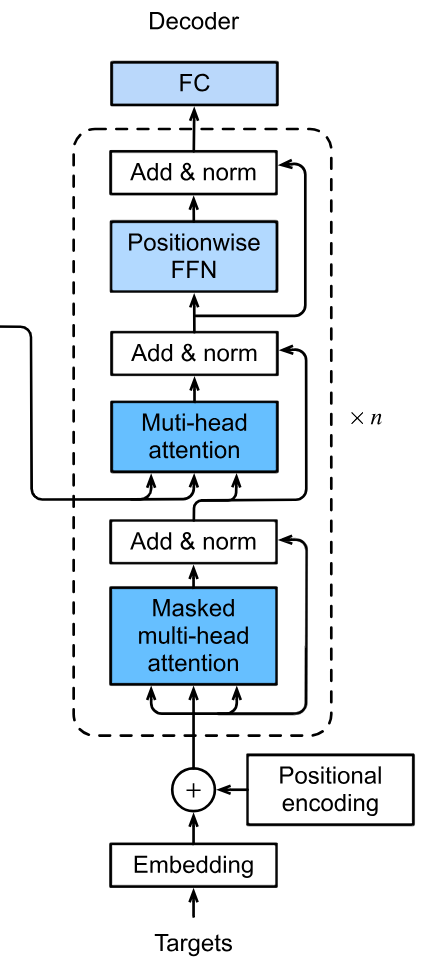

Tips to complete the Decoder below.

* Can you seperate the decoder layers from the whole decoder?
* How many multi-head attention do we have in the figure above.
* How many layer normalizations?
* How do we make the residual connections?

For Forward Method:
* What are the inputs to various multi-head attention modules?
* How do we make the residual connection (do we need dropout)?


In [112]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.mha1       = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.mha2       = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout=dropout)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.layernorm3 = torch.nn.LayerNorm(d_model)

        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)
        self.dropout3   = torch.nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask):

        # Masked Multi-Head Attention
        #   (1) apply MHA with the lookahead mask
        
        
        # casual_mask = create_mask_2(pad_mask)
        # raise EOFError
        attn1, attn_weights_block1 = self.mha1(padded_targets, padded_targets, padded_targets, slf_attn_mask)

        # Skip (Residual) Connections
        #   (1) perform dropout on padded attention output
        #   (2) add the true outputs (padded_targets) as a skip connection
        
        attn1 = padded_targets + self.dropout1(attn1)


        # Layer Normalization
        #   (1) call layernorm on this resulting value
        
        attn1 = self.layernorm1(attn1)

        # Masked Multi-Head Attention on Encoder Outputs and Targets
        #   (1) apply MHA with the self-attention mask
        
        attn2, attn_weights_block2 = self.mha2(attn1, enc_output, enc_output, dec_enc_attn_mask)

        # Skip (Residual) Connections
        #   (1) perform dropout on this second padded attention output
        #   (2) add the output of first MHA block as a skip connection
        
        attn2 = attn1 + self.dropout2(attn2)

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        
        attn2 = self.layernorm2(attn2)

        # Feed Forward Network
        #   (1) pass through the FFN
        
        ffn_output = self.ffn(attn2)

        # Skip (Residual) Connections
        #   (1) perform dropout on the output
        #   (2) add the output of second MHA block as a skip connection
        
        ffn_output = attn2 + self.dropout3(ffn_output)

        # apply Layer Normalization on this resulting value
        
        ffn_output = self.layernorm3(ffn_output)

        # return the network output and both attention weights (for mha1 and mha2)
        # @NOTE: returning the self attention weights first
        return attn_weights_block1, attn_weights_block2, ffn_output

In [113]:
class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout,
            target_vocab_size, max_seq_length, eos_token, sos_token, pad_token):
        super().__init__()

        self.EOS_TOKEN      = eos_token
        self.SOS_TOKEN      = sos_token
        self.PAD_TOKEN      = pad_token

        self.max_seq_length = max_seq_length
        self.num_layers     = num_layers

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        # @HINT: We've implemented this for you.
        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding       = torch.nn.Embedding(target_vocab_size, d_model)
        self.positional_encoding    = PositionalEncoding(d_model)
        self.final_linear           = torch.nn.Linear(d_model, target_vocab_size)
        self.dropout                = torch.nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths):

        # create a padding mask for the padded_targets with <PAD_TOKEN>
        pad_mask = padded_targets.eq(self.PAD_TOKEN)

        # creating an attention mask for the future subsequences (look-ahead mask)
        # print(padded_targets.shape)
        slf_attn_mask_subseq = create_mask_2(padded_targets)

        # creating attention mask to ignore padding positions in the input sequence during attention calculation
        dec_enc_attn_mask = create_mask_3(enc_output, enc_input_lengths, padded_targets.size(1))

        # computing embeddings for the target sequence
        x = self.target_embedding(padded_targets)

        # computing Positional Encodings with the embedded targets and apply dropout
        x = self.positional_encoding(x)
        x = self.dropout(x)

        # passing through decoder layers
        # @NOTE: store your mha1 and mha2 attention weights inside a dictionary
        # @NOTE: you will want to retrieve these later so store them with a useful name
        attn_weights = {}
        for i in range(self.num_layers):
            attn_weights[f"mha1_{i}"], attn_weights[f"mha2_{i}"], x = self.dec_layers[i](
                x, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask_subseq
            )

        # linear layer (Final Projection) for next character prediction
        seq_out = self.final_linear(x)


        # return the network output and the dictionary of attention weights
        return seq_out, attn_weights

    def recognize_greedy_search(self, enc_outputs, enc_input_lengths):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network

            @NOTE: You do not need to make changes to this method.
        '''

        batch_size = enc_outputs.size(0)

        # start with the <SOS> token for each sequence in the batch
        target_seq = torch.full((batch_size, 1), self.SOS_TOKEN, dtype=torch.long).to(enc_outputs.device)

        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_outputs.device)

        for _ in range(self.max_seq_length):

            # preparing attention masks
            # filled with ones becaues we want to attend to all the elements in the sequence
            pad_mask = torch.ones_like(target_seq).float().unsqueeze(-1)  # (batch_size x i x 1)
            slf_attn_mask_subseq = create_mask_2(target_seq)

            x = self.positional_encoding(self.target_embedding(target_seq))
            
            # print(x.shape)

            for i in range(self.num_layers):
                block1, block2, x = self.dec_layers[i](
                    x, enc_outputs, enc_input_lengths, None, pad_mask, slf_attn_mask_subseq)
                # print(x.shape)

            seq_out = self.final_linear(x[:, -1])
            logits = torch.nn.functional.log_softmax(seq_out, dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            next_token = logits.argmax(dim=-1).unsqueeze(1)

            # appending the token to the sequence
            target_seq = torch.cat([target_seq, next_token], dim=-1)

            # checking if <EOS> token is generated
            eos_mask = next_token.squeeze(-1) == self.EOS_TOKEN
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            finished |= eos_mask

            # end if all sequences have generated the EOS token
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_seq_length - max_length), value=self.PAD_TOKEN)

        return target_seq

## CNN-LSTM Encoder + Speech Transformer Decoder

In this section, let's build the first (simplest) Transformer network by combining the CNN-LSTM encoder and our Transformer Decoder.

In [114]:
class SpeechTransformer(torch.nn.Module):

    def __init__(self, input_dim, dec_num_layers, dec_num_heads,
                    d_model, d_ff, target_vocab_size, eos_token, sos_token,
                    pad_token, enc_dropout, dec_dropout, max_seq_length=512):

        super(SpeechTransformer, self).__init__()

        self.encoder    = CNN_LSTM_Encoder(input_dim, 256, enc_dropout)

        self.proj       = torch.nn.Linear(1024, d_model)

        # @NOTE: layernorm here is meant to normalize the dynamic ranges of
        #   the cross attention weights such that the model doesn't bias
        #   itself to only using the cross attention weights and neglect using
        #   the multi-head self attention weights.
        #   This is to enfoce the Language Model constraints in the Decoder.
        #   This is an experimental change -- you may try it if you want.
        # self.layernorm  = torch.nn.LayerNorm(d_model)

        self.decoder    = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                dec_dropout, target_vocab_size, max_seq_length, eos_token, sos_token, pad_token)

        # You can experiment with different weight initialization schemes or no initialization here
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):

        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        encoder_output = self.proj(encoder_output)

        # @NOTE: adding layernorm to adjust dynamic ranges of the encoder_outputs
        # @NOTE: uncomment this if you choose to use layernorm described in __init__ above
        # encoder_output = self.layernorm(encoder_output)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterence at a time """

        encoder_outputs, encoder_lens  = self.encoder(inp, inp_len)
        encoder_outputs                = self.proj(encoder_outputs)
        out                            = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Model Setup


In [115]:
torch.cuda.empty_cache()
gc.collect()

4149

In [116]:
''' Please refer to the config file and top sections to fill in the following '''

model = SpeechTransformer(
input_dim                   = config['input_dim'],
dec_num_layers              = config['dec_num_layers'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

enc_dropout                 = config['enc_dropout'],
dec_dropout                 = config['dec_dropout'],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 550 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

##########
Model Parameters:
 22.855747
##########


In [117]:
import torchinfo

# torchinfo.summary(model, input_size=(config["batch_size"], 1000, config["input_dim"]))
print(model)

SpeechTransformer(
  (encoder): CNN_LSTM_Encoder(
    (embedding): Sequential(
      (0): Conv1d(27, 54, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(54, 108, kernel_size=(5,), stride=(1,), padding=(2,))
      (4): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (bilstm): LSTM(108, 256, batch_first=True, dropout=0.2, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
      (1): LockedDropout()
      (2): pBLSTM(
        (blstm): LSTM(1024, 512, batch_first=True, bidirectional=True)
      )
      (3): LockedDropout()
    )
    (permute): PermuteBlock()
  )
  (proj): Linear(in_features=1024, out_features=512, bias=True)
  (decoder): Decoder(
    (dec_layers): ModuleList(
      (0-2): 3 x

### Loading the CNN-LSTM Checkpoint

---
For ease of training we use a pretrained LSTM -- load the .pth file.

Download the weights from here - https://drive.google.com/file/d/1wRcHwCvxksxiPv6WQykOkY9i4bip-ooa/view?usp=sharing

In [118]:
model.encoder.load_state_dict(torch.load("/mnt/w/Sync/Courses/24 Spring/11785 IDL/hw/hw4/HW4P2/pblstm_fast_training_weights.pth"))

<All keys matched successfully>

## Loss, Optimizer, and Scheduler Definitions

In [119]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [120]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

In [121]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {"model_state_dict"         : model.state_dict(),
         "optimizer_state_dict"     : optimizer.state_dict(),
         "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         "epoch"                    : epoch},
         path
    )

def load_model(path, model, metric= "valid_acc", optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    epoch   = checkpoint["epoch"]
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

## Training and Validation Modules

### Levenshtein Distance

In [122]:
''' utility function which takes a sequence of indices and converts them to a list of characters '''
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices:   # looping through all indices

        if int(i) == SOS_TOKEN:     # If SOS is encountered, don't add it to the final list
            continue
        elif int(i) == EOS_TOKEN:   # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])

    return tokens

In [123]:
''' utility function for Levenshtein Distantce quantification '''
def calc_edit_distance(predictions, y, y_len, vocab=VOCAB, print_example=False):

    dist = 0.0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx, 0 : y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # strings - when you are using characters from the SpeechDataset
        y_string    = "".join(y_sliced)
        pred_string = "".join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)

    if print_example:
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist /= batch_size

    return dist

### Training and Validation Functions

In [124]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)

            padding_mask = torch.logical_not(torch.eq(targets_shifted, PAD_TOKEN))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [125]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)
        

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=False)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5

    return running_distance

In [126]:
def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)

    return running_distance

## WandB

In [127]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False

# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"])

if USE_WANDB:

    wandb.login(key="a07bacf1f6490c2d1a0d4e22dd08701319310f93", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = ""
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "hw4p2",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "hw4p2",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        # wandb.save("model_arch.txt")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


## Experiments

In [128]:
MODEL_ROOT = "/mnt/e/Workspace/IDL/Models/hw4"

In [129]:
# validate_fast(model, val_loader)


Epoch 1/80



Epoch 1/80: 
Train Loss 2.6935	 Train Perplexity 16.3457	 Learning Rate 0.0002


Val Fast Levenshtein Distance 506.2500
Saved epoch model
Saved best training model

Epoch 2/80



Epoch 2/80: 
Train Loss 2.3028	 Train Perplexity 10.0279	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 3/80



Epoch 3/80: 
Train Loss 1.9020	 Train Perplexity 6.8596	 Learning Rate 0.0002


Val Fast Levenshtein Distance 137.0375
Saved epoch model
Saved best training model

Epoch 4/80



Epoch 4/80: 
Train Loss 1.1432	 Train Perplexity 3.1803	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 5/80



Epoch 5/80: 
Train Loss 0.7700	 Train Perplexity 2.1650	 Learning Rate 0.0002


Val Fast Levenshtein Distance 25.6812
Saved epoch model
Saved best training model

Epoch 6/80



Epoch 6/80: 
Train Loss 0.6060	 Train Perplexity 1.8348	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 7/80



Epoch 7/80: 
Train Loss 0.5126	 Train Perplexity 1.6707	 Learning Rate 0.0002


Val Fast Levenshtein Distance 19.0250
Saved epoch model
Saved best training model

Epoch 8/80



Epoch 8/80: 
Train Loss 0.4489	 Train Perplexity 1.5673	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 9/80



Epoch 9/80: 
Train Loss 0.4026	 Train Perplexity 1.4964	 Learning Rate 0.0002


Val Fast Levenshtein Distance 14.4125
Saved epoch model
Saved best training model

Epoch 10/80



Epoch 10/80: 
Train Loss 0.3664	 Train Perplexity 1.4430	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 11/80



Epoch 11/80: 
Train Loss 0.3368	 Train Perplexity 1.4008	 Learning Rate 0.0002


Val Fast Levenshtein Distance 12.8750
Saved epoch model
Saved best training model

Epoch 12/80



Epoch 12/80: 
Train Loss 0.3130	 Train Perplexity 1.3679	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 13/80



Epoch 13/80: 
Train Loss 0.2929	 Train Perplexity 1.3407	 Learning Rate 0.0002


Val Fast Levenshtein Distance 12.0375
Saved epoch model
Saved best training model

Epoch 14/80



Epoch 14/80: 
Train Loss 0.2743	 Train Perplexity 1.3159	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 15/80



Epoch 15/80: 
Train Loss 0.2593	 Train Perplexity 1.2963	 Learning Rate 0.0002


Val Fast Levenshtein Distance 11.0813
Saved epoch model
Saved best training model

Epoch 16/80



Epoch 16/80: 
Train Loss 0.2453	 Train Perplexity 1.2782	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 17/80



Epoch 17/80: 
Train Loss 0.2336	 Train Perplexity 1.2634	 Learning Rate 0.0002


Val Fast Levenshtein Distance 11.0875
Saved epoch model
Saved best training model

Epoch 18/80



Epoch 18/80: 
Train Loss 0.2225	 Train Perplexity 1.2494	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 19/80



Epoch 19/80: 
Train Loss 0.2127	 Train Perplexity 1.2372	 Learning Rate 0.0002


Val Fast Levenshtein Distance 10.5875
Saved epoch model
Saved best training model

Epoch 20/80



Epoch 20/80: 
Train Loss 0.2027	 Train Perplexity 1.2249	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 21/80



Epoch 21/80: 
Train Loss 0.1944	 Train Perplexity 1.2147	 Learning Rate 0.0002


Val Fast Levenshtein Distance 10.5000
Saved epoch model
Saved best training model

Epoch 22/80



Epoch 22/80: 
Train Loss 0.1864	 Train Perplexity 1.2051	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 23/80



Epoch 23/80: 
Train Loss 0.1793	 Train Perplexity 1.1965	 Learning Rate 0.0002


Val Fast Levenshtein Distance 9.7125
Saved epoch model
Saved best training model

Epoch 24/80



Epoch 24/80: 
Train Loss 0.1728	 Train Perplexity 1.1887	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 25/80



Epoch 25/80: 
Train Loss 0.1668	 Train Perplexity 1.1816	 Learning Rate 0.0002


Val Fast Levenshtein Distance 10.0938
Saved epoch model
Saved best training model

Epoch 26/80



Epoch 26/80: 
Train Loss 0.1608	 Train Perplexity 1.1746	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 27/80



Epoch 27/80: 
Train Loss 0.1558	 Train Perplexity 1.1687	 Learning Rate 0.0002


Val Fast Levenshtein Distance 10.2438
Saved epoch model
Saved best training model

Epoch 28/80



Epoch 28/80: 
Train Loss 0.1503	 Train Perplexity 1.1623	 Learning Rate 0.0002
Saved epoch model
Saved best training model

Epoch 29/80



Epoch 29/80: 
Train Loss 0.1458	 Train Perplexity 1.1571	 Learning Rate 0.0002


Val Fast Levenshtein Distance 9.8187
Saved epoch model
Saved best training model

Epoch 30/80



Epoch 30/80: 
Train Loss 0.1420	 Train Perplexity 1.1527	 Learning Rate 0.0002
Epoch 00030: reducing learning rate of group 0 to 1.0000e-04.
Saved epoch model
Saved best training model

Epoch 31/80



Epoch 31/80: 
Train Loss 0.1264	 Train Perplexity 1.1348	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.3562
Saved epoch model
Saved best training model

Epoch 32/80



Epoch 32/80: 
Train Loss 0.1210	 Train Perplexity 1.1287	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 33/80



Epoch 33/80: 
Train Loss 0.1178	 Train Perplexity 1.1251	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.6250
Saved epoch model
Saved best training model

Epoch 34/80



Epoch 34/80: 
Train Loss 0.1150	 Train Perplexity 1.1219	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 35/80



Epoch 35/80: 
Train Loss 0.1124	 Train Perplexity 1.1191	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.6062
Saved epoch model
Saved best training model

Epoch 36/80



Epoch 36/80: 
Train Loss 0.1101	 Train Perplexity 1.1164	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 37/80



Epoch 37/80: 
Train Loss 0.1081	 Train Perplexity 1.1143	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.3438
Saved epoch model
Saved best training model

Epoch 38/80



Epoch 38/80: 
Train Loss 0.1061	 Train Perplexity 1.1121	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 39/80



Epoch 39/80: 
Train Loss 0.1038	 Train Perplexity 1.1095	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.4125
Saved epoch model
Saved best training model

Epoch 40/80



Epoch 40/80: 
Train Loss 0.1018	 Train Perplexity 1.1073	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 41/80



Epoch 41/80: 
Train Loss 0.0998	 Train Perplexity 1.1051	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.3562
Saved epoch model
Saved best training model

Epoch 42/80



Epoch 42/80: 
Train Loss 0.0981	 Train Perplexity 1.1031	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 43/80



Epoch 43/80: 
Train Loss 0.0961	 Train Perplexity 1.1009	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.5375
Saved epoch model
Saved best training model

Epoch 44/80



Epoch 44/80: 
Train Loss 0.0942	 Train Perplexity 1.0988	 Learning Rate 0.0001
Epoch 00044: reducing learning rate of group 0 to 5.0000e-05.
Saved epoch model
Saved best training model

Epoch 45/80



Epoch 45/80: 
Train Loss 0.0882	 Train Perplexity 1.0922	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.3500
Saved epoch model
Saved best training model

Epoch 46/80



Epoch 46/80: 
Train Loss 0.0853	 Train Perplexity 1.0891	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 47/80



Epoch 47/80: 
Train Loss 0.0839	 Train Perplexity 1.0876	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.1125
Saved epoch model
Saved best training model

Epoch 48/80



Epoch 48/80: 
Train Loss 0.0827	 Train Perplexity 1.0863	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 49/80



Epoch 49/80: 
Train Loss 0.0816	 Train Perplexity 1.0851	 Learning Rate 0.0001


Val Fast Levenshtein Distance 9.3250
Saved epoch model
Saved best training model

Epoch 50/80



Epoch 50/80: 
Train Loss 0.0805	 Train Perplexity 1.0839	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 51/80


Train:  85%|████████▌ | 762/892 [03:09<00:32,  3.99it/s, loss=0.0795, perplexity=1.0828]

KeyboardInterrupt: 

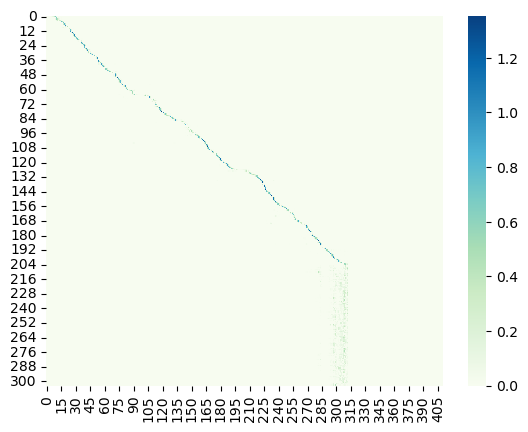

In [130]:
e                   = 0
best_loss           = 20

checkpoint_root = os.path.join(MODEL_ROOT, "checkpoints-basic-transformer2")
os.makedirs(checkpoint_root, exist_ok=True)

if USE_WANDB:
    wandb.watch(model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-model.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epoch-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(model, val_loader)
        print("Val Fast Levenshtein Distance {:.04f}".format(levenshtein_distance))

        if USE_WANDB: wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        if USE_WANDB: wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # saving the cross-attention weights
    save_attention_plot(attention_weights_decoder_cross, epoch+100, checkpoint_root + '/')

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
if USE_WANDB: run.finish()

In [131]:
validate_full(model, val_loader)

Val:   1%|          | 1/85 [00:04<06:08,  4.39s/it, running_distance=15.8750]


Ground Truth :  KALIKO HESITATED
Prediction   :  KELEGO HENSITATED


Val:   2%|▏         | 2/85 [00:06<03:50,  2.78s/it, running_distance=13.7031]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF AN ABLES SOMEN IN A TRANCE TO HOLDESBODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALS


Val:   4%|▎         | 3/85 [00:07<03:08,  2.30s/it, running_distance=12.3854]


Ground Truth :  IN A MOMENT PEGGY WAS ON THE STAGE AGAIN AND ALEXANDER APPLAUDED VIGOROUSLY WITH THE REST
Prediction   :  IT A MOMENT PEGY WAS ON THE STAGE AGAIN AND ALEXANDER APPLODED VIGOROUSLY WITH THE REST


Val:   5%|▍         | 4/85 [00:09<02:49,  2.10s/it, running_distance=10.9609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORNED YOU HAPPY THEN AT ALL


Val:   6%|▌         | 5/85 [00:11<02:43,  2.04s/it, running_distance=9.5375] 


Ground Truth :  I'VE BEEN UP IN CANADA WITH MY BRIDGE AND I ARRANGED NOT TO COME TO NEW YORK UNTIL AFTER YOU HAD GONE
Prediction   :  I'VE BEEN UP AND CANNED OUT WITH MY BRIDGE AND I ARRANGED NOT TO COME TO NEW YORK UNTIL AFTER YOU HAD GONE


Val:   7%|▋         | 6/85 [00:15<03:25,  2.60s/it, running_distance=10.3281]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLETIES OF THE JULY IN LAW THAT'S IN A FEEBLE GOVERNMENT AND A SUPER SISUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   8%|▊         | 7/85 [00:17<03:26,  2.65s/it, running_distance=10.5938]


Ground Truth :  COSETTE WAS NO LONGER IN RAGS SHE WAS IN MOURNING
Prediction   :  COSETTE WAS NO LONGER AND WRIGHS SHE WAS IN MORNING


Val:   9%|▉         | 8/85 [00:21<03:43,  2.91s/it, running_distance=11.2578]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST BLONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  11%|█         | 9/85 [00:25<04:20,  3.43s/it, running_distance=11.1667]


Ground Truth :  THE LEMON WAS FIRST CULTIVATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTURY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN HOUSES
Prediction   :  THE LEVEN WAS FIRST CULTIMATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTRY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN HOUSES


Val:  12%|█▏        | 10/85 [00:28<03:49,  3.06s/it, running_distance=10.8438]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANDER TO COVERT LETTED STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Val:  13%|█▎        | 11/85 [00:30<03:21,  2.72s/it, running_distance=10.5881]


Ground Truth :  WE STOOD PANTING ON THE EDGE OF THE RAVINE LOOKING DOWN AT THE TREES AND BUSHES THAT GREW BELOW US
Prediction   :  WE STOOD PANTING ON THE RAVENE LOOKING DOWN OF THE TREES AND WUSHES A GRUE ALOW US


Val:  14%|█▍        | 12/85 [00:33<03:41,  3.04s/it, running_distance=11.2630]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING MUSIC AND ALSO BYOLIGY ALJURE ENGLISH IN FRENCH MUSIC THESE NARTS


Val:  15%|█▌        | 13/85 [00:37<03:53,  3.25s/it, running_distance=11.2885]


Ground Truth :  IS THERE ANY CHANCE FOR THE OTHER ONE THINK YOU
Prediction   :  IS THERE ANY CHANCE FOR THE OTHER ONE THINK YOU


Val:  16%|█▋        | 14/85 [00:40<03:37,  3.06s/it, running_distance=10.9911]


Ground Truth :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INCHES HIGH AND STIFF ENOUGH TO STAND ALONE
Prediction   :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INJUST HIGH AND STIFFING OFF TO STAND ALONE


Val:  18%|█▊        | 15/85 [00:43<03:27,  2.96s/it, running_distance=10.8146]


Ground Truth :  HE COULD STAND RIGHT UP AND TALK TO YOU HE COULD DID HE FIGHT HARD
Prediction   :  HE COULD STAND RIGHT UP AND TOP TO EL HE GOD DID HE FIGHT HARD


Val:  19%|█▉        | 16/85 [00:44<03:01,  2.63s/it, running_distance=10.5312]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAG BY THE OTHER TWO


Val:  20%|██        | 17/85 [00:48<03:19,  2.93s/it, running_distance=10.6654]


Ground Truth :  SEVENTEEN SEVENTEEN
Prediction   :  SEVENTEEN SEVENTEEN


Val:  21%|██        | 18/85 [00:52<03:42,  3.31s/it, running_distance=10.8368]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  HE SAYS THAT BY CUTTING THROUGH FOUR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN THAT LEQUID


Val:  22%|██▏       | 19/85 [00:56<03:47,  3.45s/it, running_distance=10.8618]


Ground Truth :  IT WAS EVIDENT THAT THE RACE HAD DEGENERATED LIKE MANY A NOBLE RACE BESIDES IN CONSEQUENCE OF TOO STRICT A WATCHFULNESS TO KEEP IT PURE
Prediction   :  IT WAS EVIDENT THAT THE RACE HAD DEGENERATED LIKE MANY A NOBLE RACED BESIDES IN CONSEQUENCE OF TWO STRICK TO WATCHFULNESS TO KEEP AT PURE


Val:  24%|██▎       | 20/85 [00:59<03:34,  3.30s/it, running_distance=10.9984]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED IT TO GARROW TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TIGUE IT IS WATER BEWITCHED


Val:  25%|██▍       | 21/85 [01:01<03:13,  3.02s/it, running_distance=10.7946]


Ground Truth :  HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE
Prediction   :  HE WAS AN AFFEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE


Val:  26%|██▌       | 22/85 [01:03<02:40,  2.55s/it, running_distance=10.5327]


Ground Truth :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT
Prediction   :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER IN THESELF THAT HE COULD SEE HIS WAY OUT


Val:  27%|██▋       | 23/85 [01:04<02:17,  2.22s/it, running_distance=10.4552]


Ground Truth :  HE DID MANAGE TO BRING HIMSELF INTO THE MOOD TO GO OUT TO CARRIE BUT WHEN HE GOT IN OGDEN PLACE HE THOUGHT HE SAW A MAN WATCHING HIM AND WENT AWAY
Prediction   :  HE DID MANAGED TO BRING HIMSELF INTO THE MOOD TO GO OUT TO CARRY BUT WHEN HE GOT AN OGDEN PLACE HE THOUGHT HE SOUGHT MAN MATCHING HIM AND MEANT AWAY


Val:  28%|██▊       | 24/85 [01:08<02:51,  2.81s/it, running_distance=10.6263]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  I WAS TO SEE THE SHEEP NONESS AS AIRLY CLOSE AT HAND OR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT HIM OF EIGHT HUNDRED OF THEM AND BEING ALL BREATING YOUSE THEY WERE PRETTY QUIET


Val:  29%|██▉       | 25/85 [01:11<02:50,  2.85s/it, running_distance=10.8287]


Ground Truth :  THE DESIGN WAS DIFFERENT BUT THE THING WAS CLEARLY THE SAME
Prediction   :  THAT DISIDE WAS DIFFRAMBUT THE THING WAS CLEARLY THE SAME


Val:  31%|███       | 26/85 [01:13<02:30,  2.56s/it, running_distance=10.6767]


Ground Truth :  THERE APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY
Prediction   :  THEREAPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY


Val:  32%|███▏      | 27/85 [01:15<02:22,  2.46s/it, running_distance=10.4363]


Ground Truth :  IT TURNED OUT THAT SHE HAD A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR
Prediction   :  IT TURNED OUT THAT SHE HAVE A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR


Val:  33%|███▎      | 28/85 [01:17<02:01,  2.13s/it, running_distance=10.2734]


Ground Truth :  THIS MAN WAS CLAD IN A BROWN CAMEL HAIR ROBE AND SANDALS AND A GREEN TURBAN WAS ON HIS HEAD
Prediction   :  THIS MAN WAS CLAD IN A BROWN CAPTLED HERE ROBE AND SANDLES AND A GREEN TURBIT WAS ON HIS HEAD


Val:  34%|███▍      | 29/85 [01:20<02:09,  2.31s/it, running_distance=10.2866]


Ground Truth :  YES CHARCOAL
Prediction   :  YES JARKOL


Val:  35%|███▌      | 30/85 [01:21<01:59,  2.17s/it, running_distance=10.1552]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF


Val:  36%|███▋      | 31/85 [01:23<01:49,  2.03s/it, running_distance=10.1230]


Ground Truth :  ON THAT SIDE DESCENT WAS IMPOSSIBLE AND HAD IT BEEN POSSIBLE THE BOTTOM WAS SHUT IN BY THE ENORMOUS ROCK
Prediction   :  ON THAT SIDE TO SINT WAS IN TOSSIP AND HAD IT BEEN POSSIBLE BOTTON WAS SHUT IN BY THE ENORMOUS WERE ALK


Val:  38%|███▊      | 32/85 [01:28<02:26,  2.76s/it, running_distance=10.4268]


Ground Truth :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF IMMORALITY ATTACHES EITHER TO THE HEROINE OF THIS BOOK OR TO THE LEADING PHILOSOPHERS OF HER SCHOOL FOR SEVERAL CENTURIES
Prediction   :  NOT BE IT EVER REMEMBERED THAT THE SLIGHT'S SUSPICION OF THE MORALITY ATTACH YOUR TO THE HAIR WIN OF THIS BOOK OR TO THE LEADING PHILOSOPHERSE OF HER SCHOOL FOR SEVERAL CENTURIES


Val:  39%|███▉      | 33/85 [01:33<02:59,  3.45s/it, running_distance=11.5133]


Ground Truth :  NOT THAT SUCH A CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE CAN MOVE MY EQUANIMITY BUT IF I COULD STOOP TO HATE I SHOULD HATE HER HATE HER
Prediction   :  NOT THAT SUNCHER CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE AND MOVED MY EQUINIMITY BUT IF I COULD STOOPED TO PATE I SHOULD HATE HER HATE HER HATE HER HATE HER OR


Val:  40%|████      | 34/85 [01:36<02:50,  3.34s/it, running_distance=11.5138]


Ground Truth :  BUT NEITHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST HOLD THE EYE
Prediction   :  BENEITHERED THE GLORIFIED WOODS ON THE ONE HAND NO THE LAKE ON THE OTHER COULD AT FIRST COLD THE EYE


Val:  41%|████      | 35/85 [01:40<02:56,  3.53s/it, running_distance=11.6071]


Ground Truth :  I INQUIRED OF GEORGE WITH MY EYES STILL ON THIS FURTIVE WATCHER
Prediction   :  WHY INQUIRED OF GEORGE WITH MY EYES AND STILL ON OF THE SPERTITH WATCHER


Val:  42%|████▏     | 36/85 [01:41<02:23,  2.93s/it, running_distance=11.5799]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  THIS SWEECH WATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTA JAZE AND MORE OR LESS ALATHAVORIAGE


Val:  44%|████▎     | 37/85 [01:42<01:54,  2.38s/it, running_distance=11.5389]


Ground Truth :  MISS CLARKE STARTED AND HER SWEET FACE SHOWED A MOMENT'S PERPLEXITY DID I SHE QUERIED MUSINGLY
Prediction   :  MISS CLARK STARTED BUT AND AT HER SWEET FACE SHOWED A MOMENT'S PERPLEXITY AND DID I OH SHE QUERIED AM USINGLY


Val:  45%|████▍     | 38/85 [01:46<02:14,  2.86s/it, running_distance=11.6176]


Ground Truth :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDED IT TO HIM
Prediction   :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS A HANDLED TO HIM


Val:  46%|████▌     | 39/85 [01:49<02:16,  2.97s/it, running_distance=11.6707]


Ground Truth :  YET DID THE WATCHFUL MISS WOODLEY OFTENTIMES HEAR A SIGH ESCAPE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WOULD INSTANTLY OVERSPREAD HER FACE
Prediction   :  YET IT DID THE WATCH FOR MISS WOODLY OFTEN TIMES HERE A SIGH ESCATE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WOULD INSTANTLY OVER SPREAD HER FACE


Val:  47%|████▋     | 40/85 [01:52<02:14,  2.98s/it, running_distance=11.5336]


Ground Truth :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOME ZEAL
Prediction   :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOMESEL


Val:  48%|████▊     | 41/85 [01:56<02:18,  3.16s/it, running_distance=11.5038]


Ground Truth :  AT ONE MOMENT IT SEEMED TO HIM THAT HE WAS IN THE CAVE OF MONTESINOS AND SAW DULCINEA TRANSFORMED INTO A COUNTRY WENCH SKIPPING AND MOUNTING UPON HER SHE ASS AGAIN THAT THE WORDS OF THE SAGE MERLIN WERE SOUNDING IN HIS EARS SETTING FORTH THE CONDITIONS TO BE OBSERVED AND THE EXERTIONS TO BE MADE FOR THE DISENCHANTMENT OF DULCINEA
Prediction   :  AT ONE MOMENT IT SEEMED TO HIM THAT HE WAS IN THE CAVE OF MALTACINOES AND SAW DOSON THEY UP TRANSFORMED INTO A CUTRY WENCH SKIPPING AND MOUNTING UPON HER SHE ASKED AGAIN THAT THE WORDS OF THE SAGER MERLAND WERE SOUNDING IN HIS EARS SETTING FORTH A CONDITIONS TO BE MADE FOR THE DISCENT CHANTMENT OF DILSANAHAP


Val:  49%|████▉     | 42/85 [02:00<02:29,  3.47s/it, running_distance=11.6138]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  WHAT LED ME UNTIL IT WAS A CERTAINT THIRST FOR VENGEANCE WHICH IS STRONG ENOUGHTER DISTURBED THE QUIETEST HEARTS


Val:  51%|█████     | 43/85 [02:03<02:16,  3.26s/it, running_distance=11.5218]


Ground Truth :  KIRKLAND JUMPED FOR THE JETTY MISSED HIS FOOTING AND FELL INTO THE ARMS OF THE CHAPLAIN
Prediction   :  CORCLAN JUMPED FOR THE JEDDY MISSED HIS FOOTING AND FELL UNDER THE ARMS OF THE CHAPLAN


Val:  52%|█████▏    | 44/85 [02:05<01:58,  2.89s/it, running_distance=11.3892]


Ground Truth :  OUR ROADS LIE TOGETHER DOCTOR
Prediction   :  OUR ROADS LIE TOGETHERED AFTER


Val:  53%|█████▎    | 45/85 [02:06<01:37,  2.44s/it, running_distance=11.2722]


Ground Truth :  I'LL REPORT THIS TO THE GOVERNMENT
Prediction   :  I'L REPORTUS TO THE GOVERNMENT


Val:  54%|█████▍    | 46/85 [02:09<01:33,  2.39s/it, running_distance=11.2717]


Ground Truth :  HE'S A KIND NEIGHBORLY MAN AND HIS BOY WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECT YOU FAITHFULLY
Prediction   :  HE SAID KINGED NEIGHBORLY MAN AND TO SPORE WILL TAKE MY PLACE ABEL THE HOUSE AND PROTECTIE FACELY


Val:  55%|█████▌    | 47/85 [02:12<01:46,  2.80s/it, running_distance=11.4315]


Ground Truth :  DAVID AND CHRISTIE WENT SMILING AWAY TOGETHER AND IF THEY SHED ANY TEARS OVER THE BRIEF HAPPINESS NO ONE SAW THEM BUT THE FLOWERS AND THEY LOYALLY KEPT THE SECRET FOLDED UP IN THEIR TENDER HEARTS
Prediction   :  THEY IF IT IN CRISTY WENT SMILING AWAY TOGETHER AND IF THEY SHATTERN NEE TERRY SUFFERED THE BRIEF HAPPINESS NO ONE SAW THEM WITH THE FLOWERS AND THEY LOYALY KEPT THE SECRET FOLDED UP IN THEIR TENDER HEARTS


Val:  56%|█████▋    | 48/85 [02:17<02:07,  3.43s/it, running_distance=11.8763]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FIR ACTION HAVE BEEN USED UP IN THE SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HIS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TO HEAVY


Val:  58%|█████▊    | 49/85 [02:22<02:14,  3.74s/it, running_distance=12.0816]


Ground Truth :  THEY HELD CONVENTICLES IN THE OPEN FIELDS AND BEING TREATED WITH GREAT VIOLENCE AND CRUELTY BY THE SCOTTISH GOVERNMENT MORE THAN ONCE TOOK ARMS DURING THOSE REIGNS
Prediction   :  THEY HEALT CONVENTABLES IN THE OPEN FIELDS AND BEING TREATED WITH GREAT VIOLENCE IN CRUELTY BY THE SCONISH GOVERNMENT WERE THAN ONCE TOOK ARM STURING THOSE RAINS


Val:  59%|█████▉    | 50/85 [02:24<01:55,  3.29s/it, running_distance=12.0519]


Ground Truth :  YOU ARE NOT LIKE MY PEOPLE THE PINKIES AND THERE IS NO PLACE FOR YOU IN OUR COUNTRY
Prediction   :  YOU ARE NOT LIKE MY PEOPLE THE PINKEYS AND THERE IS NO PLACE FOR YOU IN OUR HUNTRY


Val:  60%|██████    | 51/85 [02:27<01:49,  3.24s/it, running_distance=12.0815]


Ground Truth :  WHEN SHE FELL THE WHOLE RACE FELL WITH HER
Prediction   :  WHEN SHE FEL THE WHOLE RAYS FELL WITH HER


Val:  61%|██████    | 52/85 [02:31<01:50,  3.35s/it, running_distance=12.2386]


Ground Truth :  THIS WAS THE FIRST BIG BATTLE IN WHICH OUR REGIMENT HAD EVER BEEN ENGAGED
Prediction   :  THIS WAS THE FIRST BIG BATTLE IN WHICH ARE REGIMENT AT EVERBEN ENGAGED


Val:  62%|██████▏   | 53/85 [02:34<01:44,  3.27s/it, running_distance=12.2235]


Ground Truth :  I MADE A QUICK GLANCE OVER MY SHOULDER AND GRABBED AT MY GUN
Prediction   :  I MADE A QUICK GLANCE OR MY SHOULDER AND GRAP IT MY GONE


Val:  64%|██████▎   | 54/85 [02:36<01:31,  2.97s/it, running_distance=12.1690]


Ground Truth :  A MAN IN THE WELL
Prediction   :  A MAN ON THE WELL


Val:  65%|██████▍   | 55/85 [02:38<01:21,  2.73s/it, running_distance=12.1068]


Ground Truth :  WITH THIS EXCEPTION GWYNPLAINE'S LAUGH WAS EVERLASTING
Prediction   :  WITH THIS EXCEPTION WHEN PLAINS LAP WAS EVER LASTING


Val:  66%|██████▌   | 56/85 [02:40<01:12,  2.49s/it, running_distance=11.9905]


Ground Truth :  IT WAS ESTABLISHED AT SOUTHWARK
Prediction   :  IT WAS ESTABLISHED A SOUTHWORK


Val:  67%|██████▋   | 57/85 [02:42<01:00,  2.18s/it, running_distance=11.8755]


Ground Truth :  HE WOULD MAKE A FAMOUS SCOUNDREL
Prediction   :  HE WOULD MAKE A FAMOUS SCOUNDREL


Val:  68%|██████▊   | 58/85 [02:44<01:01,  2.26s/it, running_distance=11.7850]


Ground Truth :  OUR TWO HORSES WITH THE LUGGAGE FOLLOWED OF THEIR OWN ACCORD WITHOUT REQUIRING WHIP OR SPUR
Prediction   :  OUR TWO HORSES WITH THE LOGAGE FALLEN OF THEIR OWN ACCORD WITHOUT REQUIRING WITH OR SPUR


Val:  69%|██████▉   | 59/85 [02:47<01:07,  2.58s/it, running_distance=11.7579]


Ground Truth :  ONE OF NEWSOME'S CHIEF PLEASURES IN LIFE HAD BEEN THE EDUCATING OF HIS WOODLAND BRIDE AND IT WAS THE AMBITION OF BOTH THAT THE LITTLE MINNETAKI AND HER BROTHER BE REARED IN THE WAYS OF WHITE CHILDREN
Prediction   :  ONE OF NEWSOM'S CHIEF PLEASURES AND LIFE HAD BEEN THE EDUCATING OF HIS WOOD THAN BRIDE AND IT WAS THE AMBITION OF BOTH THAT THE LITTLE MINUTOCKY IN HER BROTHER BE REARED IN THE WAYS OF WHITE CHORDER


Val:  71%|███████   | 60/85 [02:49<00:58,  2.32s/it, running_distance=11.7286]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  WE NEED CONTUCKING I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATY TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE


Val:  72%|███████▏  | 61/85 [02:51<00:51,  2.16s/it, running_distance=11.6460]


Ground Truth :  JUST THEN HE WAS IN NO MOOD TO THINK OF THE SORROWS
Prediction   :  JUST THEN HE WAS AND NO MOOD THINK OF THE SORROWS


Val:  73%|███████▎  | 62/85 [02:53<00:51,  2.23s/it, running_distance=11.5716]


Ground Truth :  NO I AM THE LIGHTER OF THE TWO URGED TAD
Prediction   :  NO I AM THE LIGHTER OF THE TWO URGED HAD


Val:  74%|███████▍  | 63/85 [02:56<00:48,  2.22s/it, running_distance=11.6235]


Ground Truth :  I RECKON THERE ARE SMILED THE GUIDE WE ARE IN THE BEAR COUNTRY NOW
Prediction   :  I RECKON THERE OUR SMILE DEGUITE WE ARE IN THE BARE COUNTRY NOW


Val:  75%|███████▌  | 64/85 [02:58<00:45,  2.15s/it, running_distance=11.7119]


Ground Truth :  NONE OF YOU WILL BE FIT FOR DUTY TO MORROW
Prediction   :  NOT A VIEW WILL BE FIT FOR DUTICH MORROW


Val:  76%|███████▋  | 65/85 [03:00<00:43,  2.18s/it, running_distance=11.7841]


Ground Truth :  THEN THE WIND TOOK ANOTHER FROLIC ROUND THE GARDEN AND MADE UP TO THE LARGE WHITE LILY INTO WHOSE REFINED EAR HE WHISPERED A DOUBT AS TO THE NECESSITY OR ADVANTAGE OF HER THICK POWERFUL STEM BEING PROPPED UP AGAINST A STUPID UGLY STICK
Prediction   :  THEN MEREND TOOK ANOTHER FALL AGROUND THE GARDEN AND MADE UP TO THE LARGE WHITE LILY AND WHOSE REFINED YEAR HE WHISPERED ADOUBT AS TO THE NECESSITY OR ADVANTAGE OF HER THICK POWERFUL STEM BEING PROPED UP AGAINST A STUPID UDLY STICK


Val:  78%|███████▊  | 66/85 [03:03<00:44,  2.36s/it, running_distance=11.7140]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  NOW FIFTEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAD AND HONEST OLD WOMAN SPINNING BUT SHE HAD NEVER HEARD OF THE CANXIETIC


Val:  79%|███████▉  | 67/85 [03:05<00:45,  2.52s/it, running_distance=11.6604]


Ground Truth :  I KNOW IT AND THERE IS NO WAKING
Prediction   :  I KNOW IT AND THERE IS NO WAKING


Val:  80%|████████  | 68/85 [03:07<00:35,  2.11s/it, running_distance=11.5841]


Ground Truth :  AND HE STRODE DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT
Prediction   :  AND HE STROMED DOWN BETWEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EX IT


Val:  81%|████████  | 69/85 [03:10<00:41,  2.57s/it, running_distance=11.5861]


Ground Truth :  SERVE WITH FRENCH DRESSING HIDDEN UNDER THE LEAVES OF THE NEST
Prediction   :  SERVE WITH BRENCH DRESSING HIDDEN UNDER THE LEAVES OF THE NEST


Val:  82%|████████▏ | 70/85 [03:13<00:41,  2.74s/it, running_distance=11.6156]


Ground Truth :  IN THIS SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BETWEEN MONTGOMERY AND KEARNY STREETS
Prediction   :  IN THE SAME DISTRECT IS THE MENT IN COMMERCIAL STREET BETWEN MUGHT GOME A REIN CARENEY STREETS


Val:  84%|████████▎ | 71/85 [03:15<00:34,  2.45s/it, running_distance=11.6188]


Ground Truth :  LACRIMA CHRISTI A STILL WINE OF EXCELLENT FLAVOR AND BOUQUET
Prediction   :  LOOKERY MACHESTY A STILL WINE OF EXCELLENT FLAVOUR IN BOKAY


Val:  85%|████████▍ | 72/85 [03:17<00:29,  2.27s/it, running_distance=11.6997]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  HIS OWN SKIN HAD SIZLED ON TO THE READ HOT GRANTEEMERITE SOFTLY


Val:  86%|████████▌ | 73/85 [03:19<00:25,  2.10s/it, running_distance=11.7543]


Ground Truth :  IT'S LIKE YOUR HORSE SUDDENLY FALLING DEAD UNDER YOU IN THE MIDST OF AN UNINHABITED AND THIRSTY PLAIN
Prediction   :  IT'S LIKE YOUR HORSE SOMELY FALLING DEAD UNDER YOU AND THEN THICH THEM AND AND THIRSTY PLAIN


Val:  87%|████████▋ | 74/85 [03:21<00:23,  2.15s/it, running_distance=11.7682]


Ground Truth :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATIGUE
Prediction   :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO ERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATEE


Val:  88%|████████▊ | 75/85 [03:22<00:18,  1.85s/it, running_distance=11.7225]


Ground Truth :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NYMPH
Prediction   :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NEMPH


Val:  89%|████████▉ | 76/85 [03:26<00:22,  2.46s/it, running_distance=11.7521]


Ground Truth :  MY OWN REGIMENT WAS IN THE ADVANCE
Prediction   :  MY UNE REGIMENT WAS IN THE ADMANCE


Val:  91%|█████████ | 77/85 [03:27<00:17,  2.16s/it, running_distance=11.7009]


Ground Truth :  WHEN IT WAS EVENING HE LED HIS BAND INTO A NEARBY STREET AND IN HIS DISGUISE APPROACHED THE MERCHANT'S HOUSE HE KNOCKED AT THE DOOR
Prediction   :  WHEN IT WAS EVENING HE LED HIS BANDONED TO A NEAR BY STREET AND IN HIS DISGUISE APPROACHED THE MERCHAN'S HOUSE HE KNOCKED AT THE DOOR


Val:  92%|█████████▏| 78/85 [03:30<00:15,  2.14s/it, running_distance=11.6494]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  WE ARE GOING INTO THE FOREST TO HUE WOULD AND IN THE EVENING WHEN WERE READY WE'LL COME IN FECTUE AGAIN


Val:  93%|█████████▎| 79/85 [03:35<00:18,  3.13s/it, running_distance=11.7781]


Ground Truth :  I TRIED IT YESTERDAY IT SET MY BRAINS ON FIRE I'M FEELING THAT GLASS I TOOK JUST NOW
Prediction   :  I TRY TO GUESS TO DAY IT SET MY BRAINS ON FIRE I'M FEELING THAT GLASS I TOOK JUST NOW


Val:  94%|█████████▍| 80/85 [03:36<00:12,  2.55s/it, running_distance=11.7016]


Ground Truth :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD
Prediction   :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD


Val:  95%|█████████▌| 81/85 [03:39<00:10,  2.54s/it, running_distance=11.6562]


Ground Truth :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN ENDEAVORING TO ESCAPE THE NET IN WHICH HE WAS TAKEN I RAVE
Prediction   :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN AND DOVERING TO ESCAPE THE NET IN WHICH HE WAS TAKEN I RAVE


Val:  96%|█████████▋| 82/85 [03:41<00:07,  2.45s/it, running_distance=11.6067]


Ground Truth :  NOW HELICON MUST NEEDS POUR FORTH FOR ME AND WITH HER CHOIR URANIA MUST ASSIST ME TO PUT IN VERSE THINGS DIFFICULT TO THINK
Prediction   :  NOW HOW ACON MUST NEEDS POOR FORTH FOR ME AND WITH HER QUIRE YOURONIA MUST ASSIST ME TO PUT INVERSE THINGS DIFFICULT TO THINK


Val:  98%|█████████▊| 83/85 [03:45<00:05,  2.84s/it, running_distance=11.6250]


Ground Truth :  ON JANUARY TWENTY FIFTH HE WROTE MANY AND MANY THANKS FOR A MOST ESSENTIAL SERVICE MOST THOROUGHLY PERFORMED
Prediction   :  ON JENINGARY TWENTY FIFTH HE ROTE MANY THANKS FOR MOST A SENTIAL SERVICE MOST THOROUGHLY PERFORMED


Val:  99%|█████████▉| 84/85 [03:48<00:02,  2.94s/it, running_distance=11.6373]


Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  IT IN HIS SPEPS HE LAUGHED AND MAUGHT AGAIN THEN WHILE IT WAS HIS PLEASURED REMAIN I CHANCED TO LOOK THE WAY HE HAD DRONG NEAR AND SAW THE LADIES JONE OF BEATRESS APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARBLE INSTANTLY



Ground Truth :  THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY
Prediction   :  VOW LIKE ARTUROUS STEADFAST AND A SKYS WITH TARTY SENSE GUIDEST BY KINGDOM FAIR BEARING ALONE BEL LOAD OF LIBERTY


## Testing

In [132]:
model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 82/82 [03:13<00:00,  2.43s/it]

In [133]:
# %cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("submission_p1_3.csv", index=False)

In [134]:
# !kaggle competitions submit -c hw4p2-sp24 -f test.csv -m "HW4P2 Preliminary Submission"

In [135]:
# TODO Sumbit predictions to Kaggle

# PART #2 Full Transformer (Encoder-Decoder)

Using an LSTM encoder helps to capture some dependencies in the input sequence which helps the transformer decoder to decode. However, we can do more than that. The transformer encoder plays a crucial role by processing the input sequence into a high-dimensional space, capturing complex relationships between elements. It uses self-attention to understand the context around each feature, enabling the model to grasp subtle nuances and dependencies, crucial for our speech recognition task and improving performance.

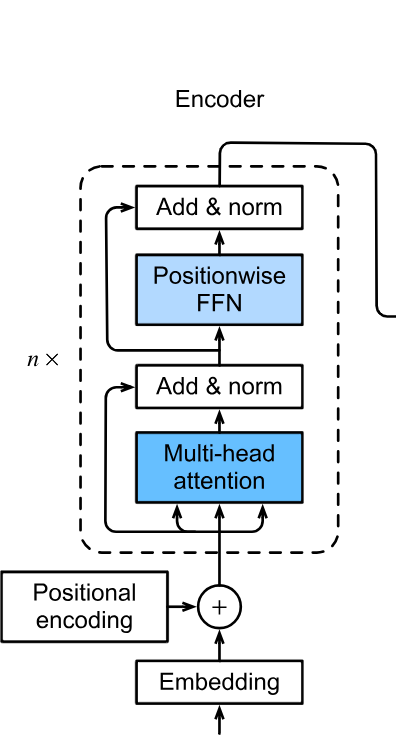

Tips in completing this section

* We will use the LSTM Encoder as input embedding.
* How many multi-head attention modules do we have.
* Can you seperate the encoder layer from the whole encoder architecture ?
* How do  we implement skip  connections
* How many layer norms do we have ?

## Transformer Encoder

In [162]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha        = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout=dropout)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)

    def forward(self, inp):

        # Multi-Head Attention
        #   (1) perform Multi-Head Attention on inp
        
        attn, attn_weights_block = self.mha(inp, inp, inp)

        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the input as a skip connection
        
        attn = inp + self.dropout1(attn)

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        
        attn = self.layernorm1(attn)

        # Feed Forward Network
        #   (1) apply feed forward layer
        
        ffn_output = self.ffn(attn)

        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the output of the first layernorm as a skip connection
       
        ffn_output = attn + self.dropout2(ffn_output)

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        
        ffn_output = self.layernorm2(ffn_output)

        return ffn_output, attn_weights_block

In [163]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(Encoder, self).__init__()

        # @TODO: fill in the blanks appropriately (given the modules above and P1 setup)
        self.embedding      = CNN_LSTM_Encoder(input_dim, 256, dropout)
        self.projection     = torch.nn.Linear(1024, d_model)
        self.pos_encoding   = PositionalEncoding(d_model)

        # concatenating all num_layers EncoderLayer blocks
        self.enc_layers     = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.dropout        = torch.nn.Dropout(dropout)
        self.layernorm      = torch.nn.LayerNorm(d_model)

    def forward(self, x, input_lengths):

        # apply the CNN-LSTM Encoder (embedding)
        x, enc_lens = self.embedding(x, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        x = self.projection(x)

        # apply Positional Encoding on these extracted features
        x = self.pos_encoding(x)

        # apply dropout as regularization technique
        x = self.dropout(x)

        # passing inputs through Transformer Encoder blocks
        for layer in self.enc_layers:
            x, _ = layer(x)

        return x, enc_lens

In [164]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.mha1       = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.mha2       = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout=dropout)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.layernorm3 = torch.nn.LayerNorm(d_model)

        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)
        self.dropout3   = torch.nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask):

        # Masked Multi-Head Attention
        #   (1) apply MHA with the lookahead mask
        
        # print(padded_targets.shape, enc_output.shape, enc_output.shape, slf_attn_mask.shape)
        # padded_targets = create_mask_2(padded_targets)
        # raise EOFError
        attn1, attn_weights_block1 = self.mha1(padded_targets, padded_targets, padded_targets, slf_attn_mask)

        # Skip (Residual) Connections
        #   (1) perform dropout on padded attention output
        #   (2) add the true outputs (padded_targets) as a skip connection
        
        attn1 = padded_targets + self.dropout1(attn1)


        # Layer Normalization
        #   (1) call layernorm on this resulting value
        
        attn1 = self.layernorm1(attn1)

        # Masked Multi-Head Attention on Encoder Outputs and Targets
        #   (1) apply MHA with the self-attention mask
        
        attn2, attn_weights_block2 = self.mha2(attn1, enc_output, enc_output, dec_enc_attn_mask)

        # Skip (Residual) Connections
        #   (1) perform dropout on this second padded attention output
        #   (2) add the output of first MHA block as a skip connection
        
        attn2 = attn1 + self.dropout2(attn2)

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        
        attn2 = self.layernorm2(attn2)

        # Feed Forward Network
        #   (1) pass through the FFN
        
        ffn_output = self.ffn(attn2)

        # Skip (Residual) Connections
        #   (1) perform dropout on the output
        #   (2) add the output of second MHA block as a skip connection
        
        ffn_output = attn2 + self.dropout3(ffn_output)

        # apply Layer Normalization on this resulting value
        
        ffn_output = self.layernorm3(ffn_output)

        # return the network output and both attention weights (for mha1 and mha2)
        # @NOTE: returning the self attention weights first
        return attn_weights_block1, attn_weights_block2, ffn_output

class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout,
            target_vocab_size, max_seq_length, eos_token, sos_token, pad_token):
        super().__init__()

        self.EOS_TOKEN      = eos_token
        self.SOS_TOKEN      = sos_token
        self.PAD_TOKEN      = pad_token

        self.max_seq_length = max_seq_length
        self.num_layers     = num_layers

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        # @HINT: We've implemented this for you.
        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding       = torch.nn.Embedding(target_vocab_size, d_model)
        self.positional_encoding    = PositionalEncoding(d_model)
        self.final_linear           = torch.nn.Linear(d_model, target_vocab_size)
        self.dropout                = torch.nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths):

        # create a padding mask for the padded_targets with <PAD_TOKEN>
        pad_mask = padded_targets.eq(self.PAD_TOKEN)

        # creating an attention mask for the future subsequences (look-ahead mask)
        # print(padded_targets.shape)
        slf_attn_mask_subseq = create_mask_2(padded_targets)

        # creating attention mask to ignore padding positions in the input sequence during attention calculation
        dec_enc_attn_mask = create_mask_3(enc_output, enc_input_lengths, padded_targets.size(1))

        # computing embeddings for the target sequence
        x = self.target_embedding(padded_targets)

        # computing Positional Encodings with the embedded targets and apply dropout
        x = self.positional_encoding(x)
        x = self.dropout(x)

        # passing through decoder layers
        # @NOTE: store your mha1 and mha2 attention weights inside a dictionary
        # @NOTE: you will want to retrieve these later so store them with a useful name
        attn_weights = {}
        for i in range(self.num_layers):
            attn_weights[f"mha1_{i}"], attn_weights[f"mha2_{i}"], x = self.dec_layers[i](
                x, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask_subseq
            )

        # linear layer (Final Projection) for next character prediction
        seq_out = self.final_linear(x)


        # return the network output and the dictionary of attention weights
        return seq_out, attn_weights

    def recognize_greedy_search(self, enc_outputs, enc_input_lengths):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network

            @NOTE: You do not need to make changes to this method.
        '''

        batch_size = enc_outputs.size(0)

        # start with the <SOS> token for each sequence in the batch
        target_seq = torch.full((batch_size, 1), self.SOS_TOKEN, dtype=torch.long).to(enc_outputs.device)

        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_outputs.device)

        for _ in range(self.max_seq_length):

            # preparing attention masks
            # filled with ones becaues we want to attend to all the elements in the sequence
            pad_mask = torch.ones_like(target_seq).float().unsqueeze(-1)  # (batch_size x i x 1)
            slf_attn_mask_subseq = create_mask_2(target_seq)

            x = self.positional_encoding(self.target_embedding(target_seq))

            for i in range(self.num_layers):
                block1, block2, x = self.dec_layers[i](
                    x, enc_outputs, enc_input_lengths, None, pad_mask, slf_attn_mask_subseq)

            seq_out = self.final_linear(x[:, -1])
            logits = torch.nn.functional.log_softmax(seq_out, dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            next_token = logits.argmax(dim=-1).unsqueeze(1)

            # appending the token to the sequence
            target_seq = torch.cat([target_seq, next_token], dim=-1)

            # checking if <EOS> token is generated
            eos_mask = next_token.squeeze(-1) == self.EOS_TOKEN
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            finished |= eos_mask

            # end if all sequences have generated the EOS token
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_seq_length - max_length), value=self.PAD_TOKEN)

        return target_seq

In [165]:
class FullTransformer(torch.nn.Module):
    def __init__(self, input_dim, enc_num_layers, dec_num_layers, enc_num_heads, dec_num_heads,
                 d_model, d_ff, target_vocab_size, eos_token, sos_token,
                 pad_token, enc_dropout=0.1, dec_dropout=0.1,trans_max_seq_length=550, mfcc_max_seq_length=3260):

        super(FullTransformer, self).__init__()

        self.encoder = Encoder(input_dim, enc_num_layers, d_model, enc_num_heads, d_ff, enc_dropout)
                            #    mfcc_max_seq_length,  enc_dropout)

        self.decoder = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                               dec_dropout, target_vocab_size, trans_max_seq_length, eos_token, sos_token, pad_token)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):
        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterance at a time """

        encoder_outputs, encoder_lens = self.encoder(inp, inp_len)
        out = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Full Model Setup

In [166]:
full_model = FullTransformer(
input_dim                   = config['input_dim'],
enc_num_layers              = config['enc_num_layers'],
dec_num_layers              = config['dec_num_layers'],
enc_num_heads               = config['enc_num_heads'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

enc_dropout                 = config['enc_dropout'],
dec_dropout                 = config['dec_dropout'],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len
).to(device)

In [167]:
print(full_model)

FullTransformer(
  (encoder): Encoder(
    (embedding): CNN_LSTM_Encoder(
      (embedding): Sequential(
        (0): Conv1d(27, 54, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(54, 108, kernel_size=(5,), stride=(1,), padding=(2,))
        (4): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (bilstm): LSTM(108, 256, batch_first=True, dropout=0.3, bidirectional=True)
      (pBLSTMs): Sequential(
        (0): pBLSTM(
          (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
        )
        (1): LockedDropout()
        (2): pBLSTM(
          (blstm): LSTM(1024, 512, batch_first=True, bidirectional=True)
        )
        (3): LockedDropout()
      )
      (permute): PermuteBlock()
    )
    (projection): Linear(in_features=1024, out_features=512, bias=

In [168]:
### Load your best P1 model checkpoint
# model.load_state_dict(torch.load(os.path.join(MODEL_ROOT, "checkpoints-basic-transformer2", "checkpoint-epoch-79.pth"))['model_state_dict'])

Freezing model weights except for transformer encoder layers. This is like an initialization strategy so that the encoder learns the range of values required by the decoder. After about 3 epochs when this initialzation is done, unfreeze weights of the entire model and let it train.




In [169]:
### Copy weights from P1 model to full model
### Freeze the weights of full transformer input embedding, linear projection, and decoder

full_model.encoder.embedding.load_state_dict(model.encoder.state_dict())
for param in full_model.encoder.embedding.parameters():
    param.requires_grad = False #  make it non-trainable

full_model.encoder.projection.load_state_dict(model.proj.state_dict())
for param in full_model.encoder.projection.parameters():
    param.requires_grad = False #  make it non-trainable

full_model.decoder.load_state_dict(model.decoder.state_dict())
for param in full_model.decoder.parameters():
    param.requires_grad = False #  make it non-trainable

## Loss, Optimizer, and Scheduler Definitions

In [170]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [171]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(full_model.parameters(),
                              lr=config["learning_rate_2"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(full_model.parameters(),
                               lr=float(config["learning_rate_2"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(full_model.parameters(), lr=float(config["learning_rate_2"]),
                                betas=(0.9, 0.999),
                                eps=1e-9,
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

## Experiments


Epoch 1/80



Epoch 1/80: 
Train Loss 0.3893	 Train Perplexity 1.4986	 Learning Rate 0.0001


Val fast Levenshtein Distance 10.1875
Saved epoch model
Saved best training model

Epoch 2/80



Epoch 2/80: 
Train Loss 0.2713	 Train Perplexity 1.3119	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 3/80



Epoch 3/80: 
Train Loss 0.2459	 Train Perplexity 1.2790	 Learning Rate 0.0001


Val fast Levenshtein Distance 10.9563
Saved epoch model
Saved best training model

Epoch 4/80



Epoch 4/80: 
Train Loss 0.2317	 Train Perplexity 1.2610	 Learning Rate 0.0001
Saved epoch model
Unfreezing the Transformers
Saved best training model

Epoch 5/80



Epoch 5/80: 
Train Loss 0.1711	 Train Perplexity 1.1870	 Learning Rate 0.0001


Val fast Levenshtein Distance 9.6250
Saved epoch model
Saved best training model

Epoch 6/80



Epoch 6/80: 
Train Loss 0.1411	 Train Perplexity 1.1516	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 7/80



Epoch 7/80: 
Train Loss 0.1302	 Train Perplexity 1.1391	 Learning Rate 0.0001


Val fast Levenshtein Distance 9.5437
Saved epoch model
Saved best training model

Epoch 8/80



Epoch 8/80: 
Train Loss 0.1233	 Train Perplexity 1.1313	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 9/80



Epoch 9/80: 
Train Loss 0.1178	 Train Perplexity 1.1251	 Learning Rate 0.0001


Val fast Levenshtein Distance 9.7125
Saved epoch model
Saved best training model

Epoch 10/80



Epoch 10/80: 
Train Loss 0.1140	 Train Perplexity 1.1209	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 11/80



Epoch 11/80: 
Train Loss 0.1105	 Train Perplexity 1.1169	 Learning Rate 0.0001


Val fast Levenshtein Distance 9.7063
Saved epoch model
Saved best training model

Epoch 12/80



Epoch 12/80: 
Train Loss 0.1071	 Train Perplexity 1.1131	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 13/80



Epoch 13/80: 
Train Loss 0.1045	 Train Perplexity 1.1102	 Learning Rate 0.0001


Val fast Levenshtein Distance 10.6750
Saved epoch model
Saved best training model

Epoch 14/80



Epoch 14/80: 
Train Loss 0.1020	 Train Perplexity 1.1075	 Learning Rate 0.0001
Epoch 00014: reducing learning rate of group 0 to 2.5000e-05.
Saved epoch model
Saved best training model

Epoch 15/80



Epoch 15/80: 
Train Loss 0.0977	 Train Perplexity 1.1027	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.6000
Saved epoch model
Saved best training model

Epoch 16/80



Epoch 16/80: 
Train Loss 0.0959	 Train Perplexity 1.1007	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 17/80



Epoch 17/80: 
Train Loss 0.0948	 Train Perplexity 1.0995	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3938
Saved epoch model
Saved best training model

Epoch 18/80



Epoch 18/80: 
Train Loss 0.0931	 Train Perplexity 1.0977	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 19/80



Epoch 19/80: 
Train Loss 0.0925	 Train Perplexity 1.0970	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.2688
Saved epoch model
Saved best training model

Epoch 20/80



Epoch 20/80: 
Train Loss 0.0913	 Train Perplexity 1.0956	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 21/80



Epoch 21/80: 
Train Loss 0.0906	 Train Perplexity 1.0948	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.4187
Epoch 00021: reducing learning rate of group 0 to 1.2500e-05.
Saved epoch model
Saved best training model

Epoch 22/80



Epoch 22/80: 
Train Loss 0.0888	 Train Perplexity 1.0929	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 23/80



Epoch 23/80: 
Train Loss 0.0877	 Train Perplexity 1.0917	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3313
Saved epoch model
Saved best training model

Epoch 24/80



Epoch 24/80: 
Train Loss 0.0871	 Train Perplexity 1.0911	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 25/80



Epoch 25/80: 
Train Loss 0.0867	 Train Perplexity 1.0906	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.4000
Saved epoch model
Saved best training model

Epoch 26/80



Epoch 26/80: 
Train Loss 0.0860	 Train Perplexity 1.0899	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 27/80



Epoch 27/80: 
Train Loss 0.0856	 Train Perplexity 1.0895	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.2250
Saved epoch model
Saved best training model

Epoch 28/80



Epoch 28/80: 
Train Loss 0.0854	 Train Perplexity 1.0892	 Learning Rate 0.0000
Epoch 00028: reducing learning rate of group 0 to 6.2500e-06.
Saved epoch model
Saved best training model

Epoch 29/80



Epoch 29/80: 
Train Loss 0.0843	 Train Perplexity 1.0880	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.4875
Saved epoch model
Saved best training model

Epoch 30/80



Epoch 30/80: 
Train Loss 0.0838	 Train Perplexity 1.0875	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 31/80



Epoch 31/80: 
Train Loss 0.0837	 Train Perplexity 1.0874	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3625
Saved epoch model
Saved best training model

Epoch 32/80



Epoch 32/80: 
Train Loss 0.0834	 Train Perplexity 1.0870	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 33/80



Epoch 33/80: 
Train Loss 0.0834	 Train Perplexity 1.0870	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.1312
Saved epoch model

Epoch 34/80



Epoch 34/80: 
Train Loss 0.0826	 Train Perplexity 1.0862	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 35/80



Epoch 35/80: 
Train Loss 0.0828	 Train Perplexity 1.0864	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.1813
Epoch 00035: reducing learning rate of group 0 to 3.1250e-06.
Saved epoch model

Epoch 36/80



Epoch 36/80: 
Train Loss 0.0823	 Train Perplexity 1.0859	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 37/80



Epoch 37/80: 
Train Loss 0.0819	 Train Perplexity 1.0854	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.2438
Saved epoch model
Saved best training model

Epoch 38/80



Epoch 38/80: 
Train Loss 0.0819	 Train Perplexity 1.0854	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 39/80



Epoch 39/80: 
Train Loss 0.0821	 Train Perplexity 1.0856	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3187
Saved epoch model

Epoch 40/80



Epoch 40/80: 
Train Loss 0.0818	 Train Perplexity 1.0853	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 41/80



Epoch 41/80: 
Train Loss 0.0816	 Train Perplexity 1.0850	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.5188
Saved epoch model
Saved best training model

Epoch 42/80



Epoch 42/80: 
Train Loss 0.0816	 Train Perplexity 1.0850	 Learning Rate 0.0000
Epoch 00042: reducing learning rate of group 0 to 1.5625e-06.
Saved epoch model

Epoch 43/80



Epoch 43/80: 
Train Loss 0.0813	 Train Perplexity 1.0847	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3500
Saved epoch model
Saved best training model

Epoch 44/80



Epoch 44/80: 
Train Loss 0.0814	 Train Perplexity 1.0848	 Learning Rate 0.0000
Saved epoch model

Epoch 45/80



Epoch 45/80: 
Train Loss 0.0812	 Train Perplexity 1.0847	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.2500
Saved epoch model
Saved best training model

Epoch 46/80



Epoch 46/80: 
Train Loss 0.0811	 Train Perplexity 1.0845	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 47/80



Epoch 47/80: 
Train Loss 0.0809	 Train Perplexity 1.0843	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.2438
Saved epoch model
Saved best training model

Epoch 48/80



Epoch 48/80: 
Train Loss 0.0808	 Train Perplexity 1.0842	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 49/80



Epoch 49/80: 
Train Loss 0.0809	 Train Perplexity 1.0843	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.4563
Epoch 00049: reducing learning rate of group 0 to 7.8125e-07.
Saved epoch model

Epoch 50/80



Epoch 50/80: 
Train Loss 0.0807	 Train Perplexity 1.0841	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 51/80



Epoch 51/80: 
Train Loss 0.0805	 Train Perplexity 1.0839	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.2875
Saved epoch model
Saved best training model

Epoch 52/80



Epoch 52/80: 
Train Loss 0.0808	 Train Perplexity 1.0842	 Learning Rate 0.0000
Saved epoch model

Epoch 53/80



Epoch 53/80: 
Train Loss 0.0805	 Train Perplexity 1.0839	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3688
Saved epoch model
Saved best training model

Epoch 54/80



Epoch 54/80: 
Train Loss 0.0804	 Train Perplexity 1.0837	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 55/80



Epoch 55/80: 
Train Loss 0.0804	 Train Perplexity 1.0838	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.4812
Saved epoch model

Epoch 56/80



Epoch 56/80: 
Train Loss 0.0804	 Train Perplexity 1.0838	 Learning Rate 0.0000
Epoch 00056: reducing learning rate of group 0 to 3.9063e-07.
Saved epoch model

Epoch 57/80



Epoch 57/80: 
Train Loss 0.0804	 Train Perplexity 1.0837	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3375
Saved epoch model

Epoch 58/80



Epoch 58/80: 
Train Loss 0.0805	 Train Perplexity 1.0839	 Learning Rate 0.0000
Saved epoch model

Epoch 59/80



Epoch 59/80: 
Train Loss 0.0804	 Train Perplexity 1.0838	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3688
Saved epoch model

Epoch 60/80



Epoch 60/80: 
Train Loss 0.0806	 Train Perplexity 1.0840	 Learning Rate 0.0000
Saved epoch model

Epoch 61/80



Epoch 61/80: 
Train Loss 0.0804	 Train Perplexity 1.0838	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.4250
Saved epoch model

Epoch 62/80



Epoch 62/80: 
Train Loss 0.0804	 Train Perplexity 1.0838	 Learning Rate 0.0000
Saved epoch model

Epoch 63/80



Epoch 63/80: 
Train Loss 0.0802	 Train Perplexity 1.0836	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3000
Epoch 00063: reducing learning rate of group 0 to 1.9531e-07.
Saved epoch model
Saved best training model

Epoch 64/80



Epoch 64/80: 
Train Loss 0.0804	 Train Perplexity 1.0837	 Learning Rate 0.0000
Saved epoch model

Epoch 65/80



Epoch 65/80: 
Train Loss 0.0803	 Train Perplexity 1.0837	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.5000
Saved epoch model

Epoch 66/80



Epoch 66/80: 
Train Loss 0.0804	 Train Perplexity 1.0837	 Learning Rate 0.0000
Saved epoch model

Epoch 67/80



Epoch 67/80: 
Train Loss 0.0803	 Train Perplexity 1.0837	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.4500
Saved epoch model

Epoch 68/80



Epoch 68/80: 
Train Loss 0.0804	 Train Perplexity 1.0837	 Learning Rate 0.0000
Saved epoch model

Epoch 69/80



Epoch 69/80: 
Train Loss 0.0806	 Train Perplexity 1.0839	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3313
Saved epoch model

Epoch 70/80



Epoch 70/80: 
Train Loss 0.0803	 Train Perplexity 1.0837	 Learning Rate 0.0000
Epoch 00070: reducing learning rate of group 0 to 9.7656e-08.
Saved epoch model

Epoch 71/80



Epoch 71/80: 
Train Loss 0.0804	 Train Perplexity 1.0837	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.4437
Saved epoch model

Epoch 72/80



Epoch 72/80: 
Train Loss 0.0803	 Train Perplexity 1.0836	 Learning Rate 0.0000
Saved epoch model

Epoch 73/80



Epoch 73/80: 
Train Loss 0.0802	 Train Perplexity 1.0836	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.2562
Saved epoch model
Saved best training model

Epoch 74/80



Epoch 74/80: 
Train Loss 0.0802	 Train Perplexity 1.0836	 Learning Rate 0.0000
Saved epoch model

Epoch 75/80



Epoch 75/80: 
Train Loss 0.0801	 Train Perplexity 1.0834	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3250
Saved epoch model
Saved best training model

Epoch 76/80



Epoch 76/80: 
Train Loss 0.0803	 Train Perplexity 1.0837	 Learning Rate 0.0000
Saved epoch model

Epoch 77/80



Epoch 77/80: 
Train Loss 0.0801	 Train Perplexity 1.0834	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.3187
Epoch 00077: reducing learning rate of group 0 to 4.8828e-08.
Saved epoch model

Epoch 78/80



Epoch 78/80: 
Train Loss 0.0801	 Train Perplexity 1.0834	 Learning Rate 0.0000
Saved epoch model

Epoch 79/80



Epoch 79/80: 
Train Loss 0.0801	 Train Perplexity 1.0835	 Learning Rate 0.0000


Val fast Levenshtein Distance 10.4437
Saved epoch model

Epoch 80/80



Epoch 80/80: 
Train Loss 0.0805	 Train Perplexity 1.0839	 Learning Rate 0.0000
Saved epoch model


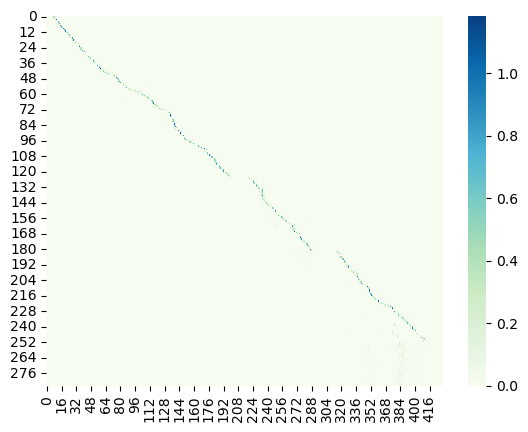

In [172]:
###  Now let's train the encoder to master the encoder input ranges
e                   = 0
best_loss           = 10.0

checkpoint_root = os.path.join(MODEL_ROOT, 'checkpointsfull3')
os.makedirs(checkpoint_root, exist_ok=True)
if USE_WANDB: wandb.watch(full_model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

RESUME_LOGGING = False

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(os.path.join(MODEL_ROOT, "checkpointsfull", "checkpoint-epochfull-46.pth"))

    full_model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(full_model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(full_model, val_loader)
        print("Val fast Levenshtein Distance {:.04f}".format(levenshtein_distance))

        if USE_WANDB: wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        if USE_WANDB: wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()
    save_attention_plot(attention_weights_decoder_cross, epoch, folder=checkpoint_root + '/')

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    # the first time we add the transformer encoder block, we freeze all other weights
    #   except the transformer encoder weights and train this partially-frozen model
    #   for about 3 epochs to weight initialize the transformer encoder weights.
    #   This speeds up convergence of the entire network.
    if epoch == 3:
        print("Unfreezing the Transformers")
        for param in full_model.encoder.embedding.parameters():
            param.requires_grad = True

        for param in full_model.encoder.projection.parameters():
            param.requires_grad = True

        for param in full_model.decoder.parameters():
            param.requires_grad = True

    if train_loss <= best_loss:
        best_loss = train_loss
        save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [173]:
validate_full(full_model, val_loader)

Val:   1%|          | 1/85 [00:09<13:30,  9.65s/it, running_distance=22.3750]


Ground Truth :  KALIKO HESITATED
Prediction   :  KELEGO HENSITATED


Val:   2%|▏         | 2/85 [00:11<06:55,  5.01s/it, running_distance=17.3281]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLES SOMEON IN A TRANCE TO HOLDESBODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   4%|▎         | 3/85 [00:13<04:49,  3.54s/it, running_distance=14.5104]


Ground Truth :  IN A MOMENT PEGGY WAS ON THE STAGE AGAIN AND ALEXANDER APPLAUDED VIGOROUSLY WITH THE REST
Prediction   :  IT A MOMENT PEGGY WAS ON THE STAGE AGAIN AND ALEXANDER APPLODED VIGOROUSLY WITH THE REST


Val:   5%|▍         | 4/85 [00:15<04:04,  3.02s/it, running_distance=12.1719]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY ENGRATITUDE WORNED YOU HAPPY THEN AT ALL


Val:   6%|▌         | 5/85 [00:17<03:31,  2.64s/it, running_distance=10.3688]


Ground Truth :  I'VE BEEN UP IN CANADA WITH MY BRIDGE AND I ARRANGED NOT TO COME TO NEW YORK UNTIL AFTER YOU HAD GONE
Prediction   :  I'VE BEEN UP AND CANNED OUT WITH MY BRIDGE AND I ARRANGED NOT TO COME TO NEW YORK UNTIL AFFER YOU HAD GONE


Val:   7%|▋         | 6/85 [00:21<04:00,  3.05s/it, running_distance=10.7500]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENDLETIES OF THE JULY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   8%|▊         | 7/85 [00:24<03:55,  3.02s/it, running_distance=11.0848]


Ground Truth :  COSETTE WAS NO LONGER IN RAGS SHE WAS IN MOURNING
Prediction   :  COSETTE WAS NO LONGER AND RIGHS SHE WAS IN MORNING


Val:   9%|▉         | 8/85 [00:32<06:12,  4.84s/it, running_distance=12.9609]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  11%|█         | 9/85 [00:41<07:43,  6.10s/it, running_distance=13.2778]


Ground Truth :  THE LEMON WAS FIRST CULTIVATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTURY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN HOUSES
Prediction   :  THE LEMON WAS FIRST CULTIMATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTRY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN HOUSES


Val:  12%|█▏        | 10/85 [00:44<06:10,  4.94s/it, running_distance=12.7531]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LETTED STUGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Val:  13%|█▎        | 11/85 [00:46<04:59,  4.04s/it, running_distance=12.3381]


Ground Truth :  WE STOOD PANTING ON THE EDGE OF THE RAVINE LOOKING DOWN AT THE TREES AND BUSHES THAT GREW BELOW US
Prediction   :  WE STOOD PANTING ON REDGE OF THE REVENE LOOKING DOWN OF THE TREES AND WUSHES A GRUEBLE LOW US


Val:  14%|█▍        | 12/85 [00:54<06:35,  5.42s/it, running_distance=13.2839]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING MUSIC AND ALSO BY OLIGY ALJOR ENGLISH IN FRENCH MUSIC THESE NARS


Val:  15%|█▌        | 13/85 [01:03<07:44,  6.44s/it, running_distance=13.4351]


Ground Truth :  IS THERE ANY CHANCE FOR THE OTHER ONE THINK YOU
Prediction   :  IS THERE ANY CHANCE FOR THE OTHER ONE THINK YOU


Val:  16%|█▋        | 14/85 [01:06<06:16,  5.30s/it, running_distance=12.9933]


Ground Truth :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INCHES HIGH AND STIFF ENOUGH TO STAND ALONE
Prediction   :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INJUST HIGH AND STIFFING OFF TO STAND ALONE


Val:  18%|█▊        | 15/85 [01:09<05:36,  4.81s/it, running_distance=12.7958]


Ground Truth :  HE COULD STAND RIGHT UP AND TALK TO YOU HE COULD DID HE FIGHT HARD
Prediction   :  HE COULD STAND RIGHT UP AND TOP TO ELL HE GOOD DID HE FIGHT HARD


Val:  19%|█▉        | 16/85 [01:11<04:31,  3.94s/it, running_distance=12.4023]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  20%|██        | 17/85 [01:20<06:01,  5.32s/it, running_distance=12.5901]


Ground Truth :  SEVENTEEN SEVENTEEN
Prediction   :  SEVENTEEN SEVENTEEN


Val:  21%|██        | 18/85 [01:29<07:21,  6.59s/it, running_distance=12.8368]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  HE SAYS THAT BY CUTTING THROUGH FOUR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN THAT LEQUID


Val:  22%|██▏       | 19/85 [01:38<07:53,  7.18s/it, running_distance=12.9770]


Ground Truth :  IT WAS EVIDENT THAT THE RACE HAD DEGENERATED LIKE MANY A NOBLE RACE BESIDES IN CONSEQUENCE OF TOO STRICT A WATCHFULNESS TO KEEP IT PURE
Prediction   :  IT WAS EVIDENT THAT THE RACE HAD DEGENERATED LIKE MANY A NOBLE RACED ASIDES IN CONSEQUENCE OF TWO STRICK TO WATCHFULNESS TO KEEP AT PURE


Val:  24%|██▎       | 20/85 [01:43<07:14,  6.69s/it, running_distance=13.1438]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GARROTIPEST BECAUSE LIKE AN OLD LADY'S CUP OF TIGUE IT IS WATER BEWITCHED


Val:  25%|██▍       | 21/85 [01:46<05:47,  5.42s/it, running_distance=12.8363]


Ground Truth :  HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE
Prediction   :  HE WAS AN AFFEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE


Val:  26%|██▌       | 22/85 [01:47<04:28,  4.25s/it, running_distance=12.4759]


Ground Truth :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT
Prediction   :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEEMLY ALIVED TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER IN THESELF THAT HE COULD SEE HIS WAY OUT


Val:  27%|██▋       | 23/85 [01:49<03:33,  3.44s/it, running_distance=12.2976]


Ground Truth :  HE DID MANAGE TO BRING HIMSELF INTO THE MOOD TO GO OUT TO CARRIE BUT WHEN HE GOT IN OGDEN PLACE HE THOUGHT HE SAW A MAN WATCHING HIM AND WENT AWAY
Prediction   :  HE DID MANAGE TO BRING HIMSELF INTO THE MOOD TO GO OUT TO CARRY BUT WHEN HE GOT AN OGDEMPLATES HE THOUGHT MAN MATCHING HIM AND MET AWAY


Val:  28%|██▊       | 24/85 [01:57<05:03,  4.97s/it, running_distance=12.5104]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  I WAS TO SEE THE SHEEP NONESS AS AIRLY CLOSE AT HAND OR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT HIM OF EIGHT HUNDRED OF THEM AND BEING ALL BREEDING USE THEY WERE PRETTY QUIET


Val:  29%|██▉       | 25/85 [02:01<04:23,  4.39s/it, running_distance=12.5337]


Ground Truth :  THE DESIGN WAS DIFFERENT BUT THE THING WAS CLEARLY THE SAME
Prediction   :  THAT DISIDE WAS DIFFRAMBAT THE THING WAS CLEARLY THE SAME


Val:  31%|███       | 26/85 [02:02<03:35,  3.64s/it, running_distance=12.2668]


Ground Truth :  THERE APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY
Prediction   :  THEREAPPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY


Val:  32%|███▏      | 27/85 [02:05<03:06,  3.22s/it, running_distance=11.9560]


Ground Truth :  IT TURNED OUT THAT SHE HAD A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR
Prediction   :  IT TURNED OUT THAT SHE HAVE A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR


Val:  33%|███▎      | 28/85 [02:06<02:31,  2.65s/it, running_distance=11.7612]


Ground Truth :  THIS MAN WAS CLAD IN A BROWN CAMEL HAIR ROBE AND SANDALS AND A GREEN TURBAN WAS ON HIS HEAD
Prediction   :  THIS MAN WAS CLAD IN A BROWN CAPBLED HERE ROBE AND SANDALS AND AGREEN TURBIT WAS ON HIS HEAD


Val:  34%|███▍      | 29/85 [02:14<04:06,  4.40s/it, running_distance=11.9095]


Ground Truth :  YES CHARCOAL
Prediction   :  YES JARKOL


Val:  35%|███▌      | 30/85 [02:16<03:22,  3.68s/it, running_distance=11.7021]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF


Val:  36%|███▋      | 31/85 [02:18<02:46,  3.09s/it, running_distance=11.6190]


Ground Truth :  ON THAT SIDE DESCENT WAS IMPOSSIBLE AND HAD IT BEEN POSSIBLE THE BOTTOM WAS SHUT IN BY THE ENORMOUS ROCK
Prediction   :  ON THAT SIDE TO CENT WAS IN TOSSIP AND HAD IT BEEN POSSIBLE BOTTON WAS SHUT IN BY THE ENORMOUS WERE ALK


Val:  38%|███▊      | 32/85 [02:27<04:12,  4.76s/it, running_distance=12.0205]


Ground Truth :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF IMMORALITY ATTACHES EITHER TO THE HEROINE OF THIS BOOK OR TO THE LEADING PHILOSOPHERS OF HER SCHOOL FOR SEVERAL CENTURIES
Prediction   :  NOT BE IT EVER REMEMBERED THAT THE SLIGHT'S SUSPICION OF THE MORALITY ATTACH YOUSIDE THERE TO THE HAIR WIN OF THIS BOOK OR TO THE LEADING PHILOSS OF HER SEVER SCHOOL FOR SEVERAL CENTURIES


Val:  39%|███▉      | 33/85 [02:37<05:29,  6.34s/it, running_distance=13.2727]


Ground Truth :  NOT THAT SUCH A CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE CAN MOVE MY EQUANIMITY BUT IF I COULD STOOP TO HATE I SHOULD HATE HER HATE HER
Prediction   :  NOT THAT SUCHER CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE AND MOVED MY EQUINIMITY BUT IF I COULD STOOP TO PATE I SHOULD HATE HER HATE HER


Val:  40%|████      | 34/85 [02:40<04:32,  5.35s/it, running_distance=13.1756]


Ground Truth :  BUT NEITHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST HOLD THE EYE
Prediction   :  BENEITHERED THE GOLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST COLD THE EYE


Val:  41%|████      | 35/85 [02:49<05:23,  6.47s/it, running_distance=13.2777]


Ground Truth :  I INQUIRED OF GEORGE WITH MY EYES STILL ON THIS FURTIVE WATCHER
Prediction   :  I INQUIRED OF GEORGE WITH MY EYES AND STILL ON THE SPURDITH WATCHER


Val:  42%|████▏     | 36/85 [02:51<04:06,  5.03s/it, running_distance=13.1571]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  THIS SWEECH WATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTA JAZE AND MORE OR LESS OLOTHAVORITE


Val:  44%|████▎     | 37/85 [02:52<03:06,  3.88s/it, running_distance=13.0650]


Ground Truth :  MISS CLARKE STARTED AND HER SWEET FACE SHOWED A MOMENT'S PERPLEXITY DID I SHE QUERIED MUSINGLY
Prediction   :  MISS CLARK STARTED BET AT HER SWEET FACE SHOWED A MOMENT'S PERPLEXITY AT DID I SHE QUERIED HIM USINGLY


Val:  45%|████▍     | 38/85 [03:01<04:14,  5.41s/it, running_distance=13.1768]


Ground Truth :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDED IT TO HIM
Prediction   :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDLED TO HIM


Val:  46%|████▌     | 39/85 [03:05<03:47,  4.94s/it, running_distance=13.1354]


Ground Truth :  YET DID THE WATCHFUL MISS WOODLEY OFTENTIMES HEAR A SIGH ESCAPE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WOULD INSTANTLY OVERSPREAD HER FACE
Prediction   :  YET IT DID THE WATCH FOR MISS WOODLY OFTEN TIMES HERE A SIGH ESCATE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WOULD INSTANTLY OVERSPREAD HER FACE


Val:  47%|████▋     | 40/85 [03:08<03:18,  4.40s/it, running_distance=12.9922]


Ground Truth :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOME ZEAL
Prediction   :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOMESEAL


Val:  48%|████▊     | 41/85 [03:11<03:00,  4.10s/it, running_distance=12.9261]


Ground Truth :  AT ONE MOMENT IT SEEMED TO HIM THAT HE WAS IN THE CAVE OF MONTESINOS AND SAW DULCINEA TRANSFORMED INTO A COUNTRY WENCH SKIPPING AND MOUNTING UPON HER SHE ASS AGAIN THAT THE WORDS OF THE SAGE MERLIN WERE SOUNDING IN HIS EARS SETTING FORTH THE CONDITIONS TO BE OBSERVED AND THE EXERTIONS TO BE MADE FOR THE DISENCHANTMENT OF DULCINEA
Prediction   :  AT ONE MOMENT IT SEEMED TO HIM THAT HE WAS IN THE CAVE OF MALTASINOES AND SAW DOSSON THEY UP TRANSFORMED INTO A CUTRY WENCH SKIPPING AND MOUNTING UPON HER SHE ASKED AGAIN THAT THE WORDS OF THE SAGER MERLAND WERE SOUNDING IN HIS EARS SETTING FORTH A CONDITIONS TO BE MADE FOR THE DISCENCHANTMENT OF DILSONAEAP


Val:  49%|████▉     | 42/85 [03:20<04:00,  5.60s/it, running_distance=13.4457]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  WHAT LED ME UNTIL IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS


Val:  51%|█████     | 43/85 [03:23<03:23,  4.85s/it, running_distance=13.2951]


Ground Truth :  KIRKLAND JUMPED FOR THE JETTY MISSED HIS FOOTING AND FELL INTO THE ARMS OF THE CHAPLAIN
Prediction   :  COURCLAN JUMPED FOR THE JEDDY MISSED HIS FOOTING AND FELL UNDER THE ARMS OF THE CHAPLAN


Val:  52%|█████▏    | 44/85 [03:26<02:44,  4.02s/it, running_distance=13.1087]


Ground Truth :  OUR ROADS LIE TOGETHER DOCTOR
Prediction   :  OUR ROADS LIE TOGETHERED AFTER


Val:  53%|█████▎    | 45/85 [03:27<02:10,  3.25s/it, running_distance=12.9486]


Ground Truth :  I'LL REPORT THIS TO THE GOVERNMENT
Prediction   :  I'LL REPORTUS TO THE GOVERNMENT


Val:  54%|█████▍    | 46/85 [03:29<01:56,  3.00s/it, running_distance=12.9015]


Ground Truth :  HE'S A KIND NEIGHBORLY MAN AND HIS BOY WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECT YOU FAITHFULLY
Prediction   :  HE SO KINGE SHE NEIGHBORLY MAN AND TO SPORE WILL TAKE MY PLACE ABELT THE HOUSE AND PROTECTY FACELY


Val:  55%|█████▌    | 47/85 [03:38<02:57,  4.68s/it, running_distance=13.1004]


Ground Truth :  DAVID AND CHRISTIE WENT SMILING AWAY TOGETHER AND IF THEY SHED ANY TEARS OVER THE BRIEF HAPPINESS NO ONE SAW THEM BUT THE FLOWERS AND THEY LOYALLY KEPT THE SECRET FOLDED UP IN THEIR TENDER HEARTS
Prediction   :  THEY IF IT IN CHRISTY WENT SMILING AWAY TOGETHER AND IF THEY SHATTERNEY TERRY SUFFERED THE BRIEF HAPPINESS NO ONE SAW THEM WITH THE FLOWERS AND THEY LOYALLY KEPT THE SECRET FOLDED UP IN THEIR TENDER HEARTS


Val:  56%|█████▋    | 48/85 [03:48<03:55,  6.36s/it, running_distance=14.0573]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FIRECTION HAVE BEEN USED UP IN THE SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HIS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TO HEAVY


Val:  58%|█████▊    | 49/85 [03:54<03:42,  6.18s/it, running_distance=14.1677]


Ground Truth :  THEY HELD CONVENTICLES IN THE OPEN FIELDS AND BEING TREATED WITH GREAT VIOLENCE AND CRUELTY BY THE SCOTTISH GOVERNMENT MORE THAN ONCE TOOK ARMS DURING THOSE REIGNS
Prediction   :  THEY HELD CONVENTABLES IN THE OPEN FIELDS AND BEING TREATED WITH GREAT VIOLENCE IN CRUELTY BY THE SCOTTISH GOVERNMENT WERE THAN ONCE TOOK ARM STURING THOSE RAINS


Val:  59%|█████▉    | 50/85 [03:56<02:56,  5.03s/it, running_distance=14.0844]


Ground Truth :  YOU ARE NOT LIKE MY PEOPLE THE PINKIES AND THERE IS NO PLACE FOR YOU IN OUR COUNTRY
Prediction   :  YOU ARE NOT LIKE MY PEOPLE THE PINKEYS AND THERE IS NO PLACE FOR YOU IN OUR HUNTRY


Val:  60%|██████    | 51/85 [04:00<02:32,  4.49s/it, running_distance=14.0919]


Ground Truth :  WHEN SHE FELL THE WHOLE RACE FELL WITH HER
Prediction   :  WHEN SHE FELT THE WHOLE RAYS FELL WITH HER


Val:  61%|██████    | 52/85 [04:08<03:06,  5.64s/it, running_distance=14.2993]


Ground Truth :  THIS WAS THE FIRST BIG BATTLE IN WHICH OUR REGIMENT HAD EVER BEEN ENGAGED
Prediction   :  THIS WAS THE FIRST BIG BATTLE IN WHICH ARE REGIMENT AT EVERBEN ENGAGED


Val:  62%|██████▏   | 53/85 [04:11<02:35,  4.87s/it, running_distance=14.2317]


Ground Truth :  I MADE A QUICK GLANCE OVER MY SHOULDER AND GRABBED AT MY GUN
Prediction   :  I MADE A QUICK GLANCE OR MY SHOULDER AND GRAB IT MIGHT GONE


Val:  64%|██████▎   | 54/85 [04:13<02:04,  4.03s/it, running_distance=14.1331]


Ground Truth :  A MAN IN THE WELL
Prediction   :  A MAN ON THE WELL


Val:  65%|██████▍   | 55/85 [04:15<01:43,  3.44s/it, running_distance=14.0330]


Ground Truth :  WITH THIS EXCEPTION GWYNPLAINE'S LAUGH WAS EVERLASTING
Prediction   :  WITH THIS EXCEPTION WHEN PLAINS LAP WAS EVER LASTING


Val:  66%|██████▌   | 56/85 [04:17<01:27,  3.02s/it, running_distance=13.8884]


Ground Truth :  IT WAS ESTABLISHED AT SOUTHWARK
Prediction   :  IT WAS ESTABLISHED HIS SOUTHWORK


Val:  67%|██████▋   | 57/85 [04:19<01:11,  2.57s/it, running_distance=13.7374]


Ground Truth :  HE WOULD MAKE A FAMOUS SCOUNDREL
Prediction   :  HE WOULD MAKE A FAMOUS SCOUNDREL


Val:  68%|██████▊   | 58/85 [04:21<01:08,  2.56s/it, running_distance=13.6158]


Ground Truth :  OUR TWO HORSES WITH THE LUGGAGE FOLLOWED OF THEIR OWN ACCORD WITHOUT REQUIRING WHIP OR SPUR
Prediction   :  OUR TWO HORSES WITH THE LOGGAGE FALLEN OF THEIR OWN ACCORD WITHOUT REQUIRING WITH OR SPUR


Val:  69%|██████▉   | 59/85 [04:25<01:12,  2.80s/it, running_distance=13.5519]


Ground Truth :  ONE OF NEWSOME'S CHIEF PLEASURES IN LIFE HAD BEEN THE EDUCATING OF HIS WOODLAND BRIDE AND IT WAS THE AMBITION OF BOTH THAT THE LITTLE MINNETAKI AND HER BROTHER BE REARED IN THE WAYS OF WHITE CHILDREN
Prediction   :  ONE OF NEWSOM'S CHIEF PLEASURES AND LIFE HAD BEEN THE EDUCATING OF HIS WOOD THAN BRIDE AND IT WAS THE AMBITION OF BOTH THAT THE LITTLE MINUTOCKY IN HER BROTHER BE REARED IN THE WAYS OF WHITE CHOLDER


Val:  71%|███████   | 60/85 [04:26<01:02,  2.52s/it, running_distance=13.4875]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  WE NEED CONTUCKING I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATY TWO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE


Val:  72%|███████▏  | 61/85 [04:28<00:55,  2.32s/it, running_distance=13.3735]


Ground Truth :  JUST THEN HE WAS IN NO MOOD TO THINK OF THE SORROWS
Prediction   :  JUST THEN HE WAS AND NO MOOD TO THINK OF THE SORROWS


Val:  73%|███████▎  | 62/85 [04:31<00:54,  2.39s/it, running_distance=13.2712]


Ground Truth :  NO I AM THE LIGHTER OF THE TWO URGED TAD
Prediction   :  NO I AM THE LIGHTER OF THE TWO URGED HAD


Val:  74%|███████▍  | 63/85 [04:33<00:51,  2.33s/it, running_distance=13.2862]


Ground Truth :  I RECKON THERE ARE SMILED THE GUIDE WE ARE IN THE BEAR COUNTRY NOW
Prediction   :  I RECKON THERE OUR SMILE DEGUITE WE ARE IN THE BARCOUNTRY NOW


Val:  75%|███████▌  | 64/85 [04:35<00:46,  2.23s/it, running_distance=13.3525]


Ground Truth :  NONE OF YOU WILL BE FIT FOR DUTY TO MORROW
Prediction   :  NOT A VIEW WILL BE FIT FOR DUTIGE MORROW


Val:  76%|███████▋  | 65/85 [04:37<00:44,  2.20s/it, running_distance=13.3904]


Ground Truth :  THEN THE WIND TOOK ANOTHER FROLIC ROUND THE GARDEN AND MADE UP TO THE LARGE WHITE LILY INTO WHOSE REFINED EAR HE WHISPERED A DOUBT AS TO THE NECESSITY OR ADVANTAGE OF HER THICK POWERFUL STEM BEING PROPPED UP AGAINST A STUPID UGLY STICK
Prediction   :  THEN MOREND TO TOOK ANOTHER FALL AGROUND THE GARDEN AND MADE UP TO THE LARGE WHITE LILY AND WHOSE REFINED YEAR HE WHISPERED ADOUBT AS TO THE NECESSITY OR ADVANTAGE OF HER THICK POWERFUL STEM BEING PROPPED UP AGAINST A STUPID UDLY STICK


Val:  78%|███████▊  | 66/85 [04:40<00:45,  2.38s/it, running_distance=13.2888]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAD AND HONEST OLD WOMAN SPINNING SHE HAD NEVER HEARD OF THE CANXITIC


Val:  79%|███████▉  | 67/85 [04:48<01:15,  4.21s/it, running_distance=13.2826]


Ground Truth :  I KNOW IT AND THERE IS NO WAKING
Prediction   :  I KNOW IT AND THERE IS AN AWAKING


Val:  80%|████████  | 68/85 [04:50<00:56,  3.31s/it, running_distance=13.1834]


Ground Truth :  AND HE STRODE DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT
Prediction   :  AND HE STROOMED DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EX IT


Val:  81%|████████  | 69/85 [04:58<01:16,  4.79s/it, running_distance=13.2473]


Ground Truth :  SERVE WITH FRENCH DRESSING HIDDEN UNDER THE LEAVES OF THE NEST
Prediction   :  SERVE WITH FRENCH DRESSING HIDDEN UNDER THE LEAVES OF THE NEST


Val:  82%|████████▏ | 70/85 [05:01<01:05,  4.39s/it, running_distance=13.2388]


Ground Truth :  IN THIS SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BETWEEN MONTGOMERY AND KEARNY STREETS
Prediction   :  IN THE SAME DISTRECT IS THE MEANT IN COMMERCIAL STREET BETWEEN MOT GOME A REIN CARNEY STREETS


Val:  84%|████████▎ | 71/85 [05:03<00:51,  3.67s/it, running_distance=13.2271]


Ground Truth :  LACRIMA CHRISTI A STILL WINE OF EXCELLENT FLAVOR AND BOUQUET
Prediction   :  LOOKERY MACHISTEE A STILL WINE OF EXCELLENT FLAVOR IN BOKAY


Val:  85%|████████▍ | 72/85 [05:05<00:41,  3.17s/it, running_distance=13.2873]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  HIS OWN SKIN HAD SIZZLED ON TO THE RED HOT GRANTEEMEROD SOUGHTLY


Val:  86%|████████▌ | 73/85 [05:07<00:33,  2.75s/it, running_distance=13.3048]


Ground Truth :  IT'S LIKE YOUR HORSE SUDDENLY FALLING DEAD UNDER YOU IN THE MIDST OF AN UNINHABITED AND THIRSTY PLAIN
Prediction   :  IT'S LIKE YOUR HORSE SOMELY FALLING DEAD UNDER YOU AND THEN THICH THEM HAD HAVITED AND THIRSTY PLAIN


Val:  87%|████████▋ | 74/85 [05:10<00:31,  2.91s/it, running_distance=13.2800]


Ground Truth :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATIGUE
Prediction   :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUST OF LABOR WITHOUT FATEE


Val:  88%|████████▊ | 75/85 [05:12<00:23,  2.39s/it, running_distance=13.2192]


Ground Truth :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NYMPH
Prediction   :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NIMPH


Val:  89%|████████▉ | 76/85 [05:21<00:39,  4.37s/it, running_distance=13.2603]


Ground Truth :  MY OWN REGIMENT WAS IN THE ADVANCE
Prediction   :  MY UNREGIMENT WAS IN THE ADMANCE


Val:  91%|█████████ | 77/85 [05:22<00:27,  3.50s/it, running_distance=13.1993]


Ground Truth :  WHEN IT WAS EVENING HE LED HIS BAND INTO A NEARBY STREET AND IN HIS DISGUISE APPROACHED THE MERCHANT'S HOUSE HE KNOCKED AT THE DOOR
Prediction   :  WHEN IT WAS EVENING HE LED HIS BANDONED TO A NEAR BY STREET AND IN HIS DISGUISE APPROACHED THE MERCHAN'S HOUSE HE KNOCKED AT THE DOOR


Val:  92%|█████████▏| 78/85 [05:24<00:21,  3.03s/it, running_distance=13.1282]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  WE ARE GOING INTO THE FORCE TO HUE WOULD AND IN THE EVENING ONE WERE READY WE'LL COME INFECTUE AGAIN


Val:  93%|█████████▎| 79/85 [05:32<00:26,  4.49s/it, running_distance=13.2733]


Ground Truth :  I TRIED IT YESTERDAY IT SET MY BRAINS ON FIRE I'M FEELING THAT GLASS I TOOK JUST NOW
Prediction   :  I TRIDED YES TO DAY IT SET MY BRAINS ON FIRE I'M FEELING THAT GLASS I TOOK JUST NOW


Val:  94%|█████████▍| 80/85 [05:33<00:17,  3.49s/it, running_distance=13.1738]


Ground Truth :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD
Prediction   :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD


Val:  95%|█████████▌| 81/85 [05:36<00:13,  3.28s/it, running_distance=13.1100]


Ground Truth :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN ENDEAVORING TO ESCAPE THE NET IN WHICH HE WAS TAKEN I RAVE
Prediction   :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN AND DOVERING TO ESCAPE THE NET IN WHICH HE WAS TAKEN I RAVE


Val:  96%|█████████▋| 82/85 [05:38<00:08,  2.98s/it, running_distance=13.0408]


Ground Truth :  NOW HELICON MUST NEEDS POUR FORTH FOR ME AND WITH HER CHOIR URANIA MUST ASSIST ME TO PUT IN VERSE THINGS DIFFICULT TO THINK
Prediction   :  NOW HELE ACON MUST NEEDS POOR FORTH FOR ME AND WITH HER QUIRE YOURONIA MUST ASSIST ME TO PUT INVERSE THINGS DIFFICULT TO THINK


Val:  98%|█████████▊| 83/85 [05:47<00:09,  4.66s/it, running_distance=13.1047]


Ground Truth :  ON JANUARY TWENTY FIFTH HE WROTE MANY AND MANY THANKS FOR A MOST ESSENTIAL SERVICE MOST THOROUGHLY PERFORMED
Prediction   :  ON JING RETWENTY FIFTH HE WROTE MANY THANKS FOR MOST ESSENTIAL SERVICE MOST THOROUGHLY PERFORMED


Val:  99%|█████████▉| 84/85 [05:50<00:04,  4.15s/it, running_distance=13.0871]


Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  IT IN HIS SPEEP SHE LAUGHED AND MAUGHT AGAIN THEN WHILE IT WAS HIS PLEASURED REMAIN I CHANCED TO LOOK THE WAY HE HAD DRONG NEAR AND SAW THE LADIES JONE OF BEATRESS APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARBLE INSTANTLY



Ground Truth :  THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY
Prediction   :  VOW LIKE ARTUROUS STEADFAST IN A SKYS WITH TARTY SENSE GUIDEST BY KINGDOM FAIR BEARING ALONE BULLOWED OF LIBERTY


13.408382352941178

In [174]:
### TODO Unfreeze the weights of full transformer input embedding and decoder
# # @NOTE: after unfreezing, continue training the P2 model for more epochs to achieve best results!

# for param in full_model.encoder.embedding.parameters():
#     param.requires_grad = NotImplemented # TODO make it trainable

# for param in full_model.encoder.projection.parameters():
#     param.requires_grad = NotImplemented # TODO make it trainable

# for param in full_model.decoder.parameters():
#     param.requires_grad = NotImplemented # TODO make it trainable

## Testing

In [180]:
#Load best:
full_model.load_state_dict(torch.load(os.path.join(MODEL_ROOT, "checkpointsfull3", "checkpoint-best-loss-modelfull.pth"))['model_state_dict'])

full_model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = full_model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 82/82 [05:26<00:00,  3.69s/it]

In [181]:
# %cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("submission_full_5.csv", index=False)

In [182]:
# !kaggle competitions submit -c hw4p2-sp24 -f improved.csv -m "It's been a ride :)"

# Part #3 (Improving your Model)
* Think of the input embedding, can you have something better than just an CNN-LSTM? Hint: HW3P2 might perform better.
* Think about the transformer encoder parameter, what about number of heads and number of layers, can this help?
* What about the decoder parameters what can  we improve there?
* We trained using an incremental training technique, can we use this technique to add more layers?

**Good Luck!!**